In [1]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')


import pandas as pd
import torch
import numpy as np

import src.inference as inf


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go

In [2]:
VALIDATION = True
directory = 'checkpoint/msn-complete-br-data' 
config_file = "params-temperature-exp-2-c30.yaml"
read_path="results/temperature"

params, dataset = inf.read_data(directory,config_file,validation=VALIDATION)
target_encoder, prot = inf.load_model(params)

E, F = inf.get_model_results(read_path)

if VALIDATION:
    E_val, F_val = inf.get_model_results(read_path, validation=True)

tsne_E, tsne_prot, tsne_Eval = inf.get_TSNE(read_path, validation=VALIDATION)

INFO:root:data loader created
Loaded E and F from results/temperature
Loaded E and F from results/temperature


In [ ]:
pca_E, pca_prot, pca_Eval = inf.get_pca(read_path, E=E, prot=prot, E_val=E_val, validation=VALIDATION)

KeyError: 'E'

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_nd = torch.concat([features, swav_prototypes], axis=0)
pca_2d = pca.fit_transform(pca_nd)

n_projs = len(features)
proj_2d, prot_2d = pca_2d[:n_projs, :], pca_2d[n_projs:, :]

# Plot the PCA results
cluster_labels = features.argmax(axis=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
for i, (x, y) in enumerate(prot_2d):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("PCA of Latent Points and Prototypes")
plt.show()

In [3]:
cluster_prob, cluster_id = torch.max(F, dim=1) 
df = pd.DataFrame({"cluster_id": cluster_id.cpu(), "cluster_prob": cluster_prob.cpu(),
                   'sample_type':'train','date':dataset.time})

if VALIDATION:

    val_cluster_prob, val_cluster_id = torch.max(F_val, dim=1) # Obtém os valores máximos e seus índices
    df_val = pd.DataFrame({"cluster_id": val_cluster_id.cpu(),"cluster_prob": val_cluster_prob.cpu(),
                           'sample_type':'val','date':dataset.val_time})
        

    df =  pd.concat([df,df_val]).reset_index(drop=True) 
    df = df.sort_values('date')
    
    combined_dataset = torch.cat((dataset[:][0], dataset.validation_imgs))[df.index]

    df = df.reset_index(drop=True)  

else:
    combined_dataset = dataset[:][0]

tmin = combined_dataset[:,0,:,:]
tmax = combined_dataset[:,0,:,:]

## 1. Caracterizando os Clusters

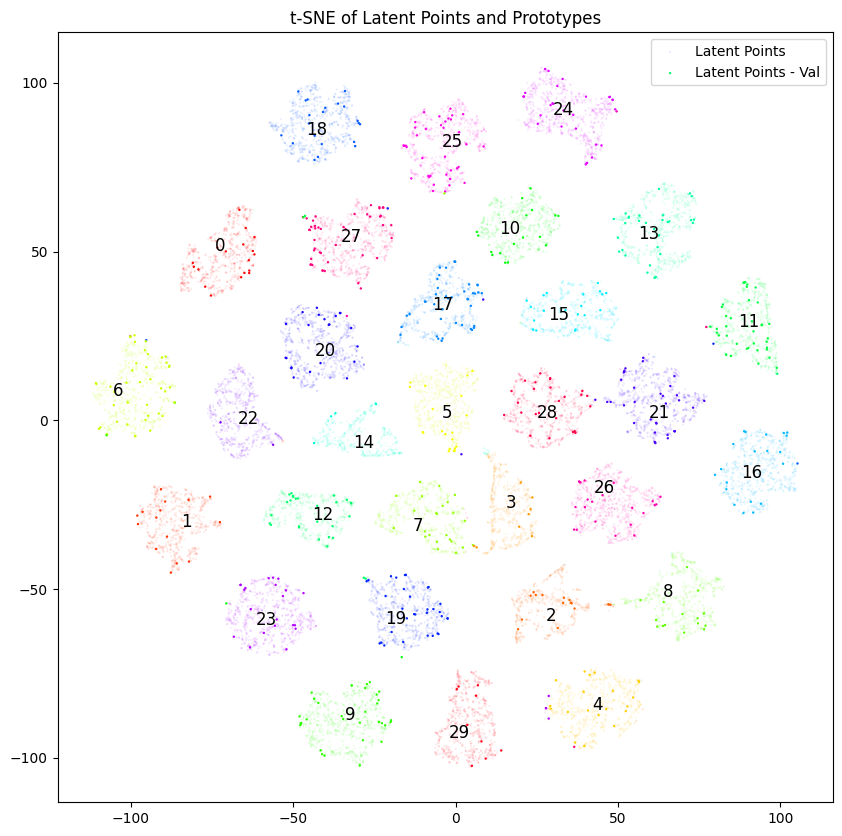

In [ ]:
# Plot the TSNE results
plt.figure(figsize=(10, 10))

cluster_labels = F.argmax(axis=1).cpu().numpy()
plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points', s=0.2,alpha=0.1 if VALIDATION else 1)

if VALIDATION:
    cluster_labels = F_val.argmax(axis=1).cpu().numpy()
    plt.scatter(tsne_Eval[:, 0], tsne_Eval[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points - Val', s=0.5)
   
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")

plt.show()

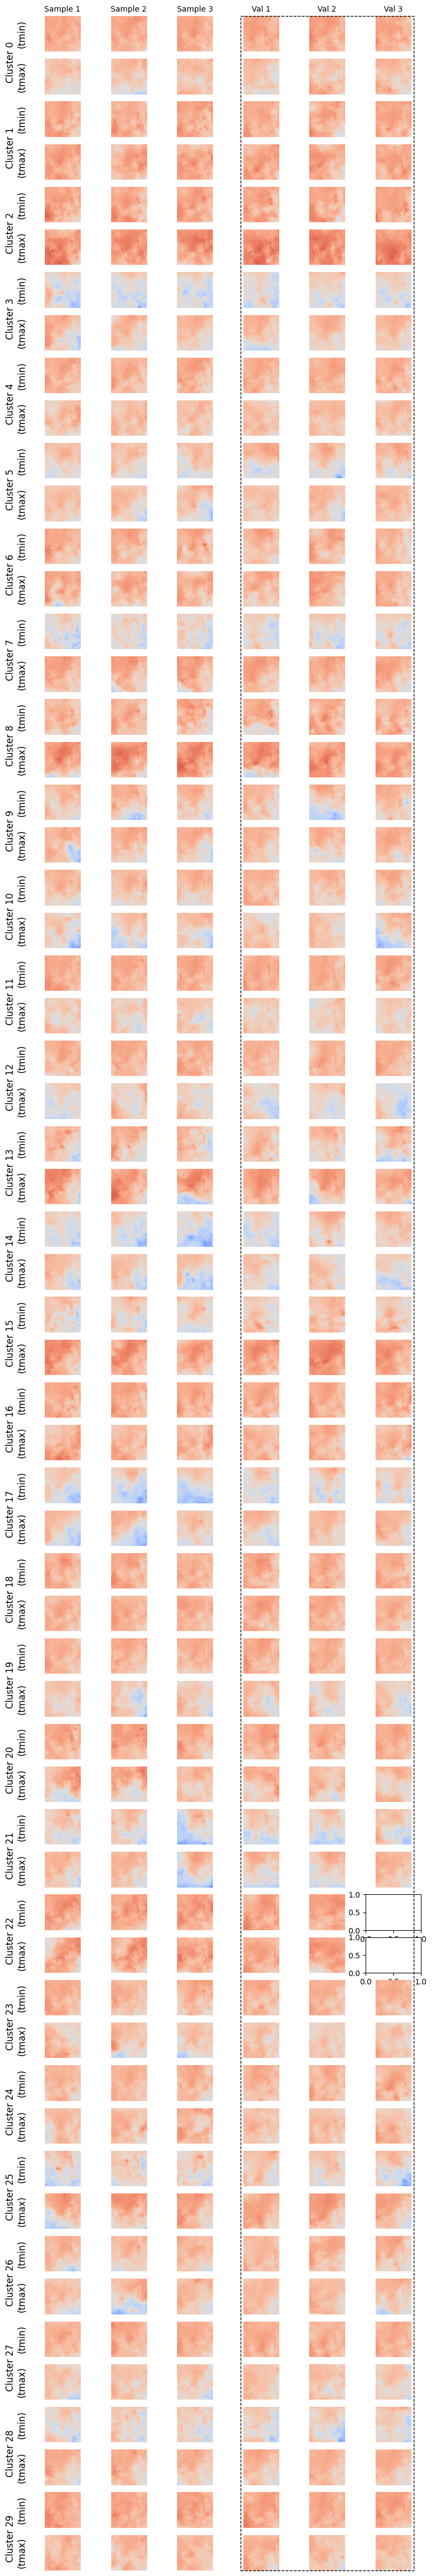

In [ ]:
Top = 3

if VALIDATION:
    fig, axes = plt.subplots(params['criterion']['num_proto']*2, Top * 2, figsize=(Top * 3, params['criterion']['num_proto'] * 2)) 
else:
    fig, axes = plt.subplots(params['criterion']['num_proto']*2, Top, figsize=(Top , params['criterion']['num_proto'])) 
    
row_n = 0
for i in range(params['criterion']['num_proto']):

    top_samples = df[(df["cluster_id"] == i) & (df["sample_type"] == "train")].nlargest(Top, "cluster_prob")

    for j, im_index in enumerate(top_samples.index):
        image_data = combined_dataset[im_index]

        ax_tmin = axes[row_n, j]
        ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
        ax_tmin.axis("off")
        
        if i == 0: # Adiciona título da coluna apenas na primeira linha
            ax_tmin.set_title(f"Sample {j+1}", fontsize=10)
            
        ax_tmax = axes[row_n+1, j] # Correção do índice para a segunda dimensão
        ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
        ax_tmax.axis("off")

    if VALIDATION:
        top_samples = df[(df["cluster_id"] == i) & (df['sample_type']=='val')].nlargest(Top, "cluster_prob")

        for j, im_index in enumerate(top_samples.index):
            image_data = combined_dataset[im_index]

            ax_tmin = axes[row_n, j+Top]
            ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
            ax_tmin.axis("off")
            
            if i == 0: 
                ax_tmin.set_title(f"Val {j+1}", fontsize=10)
                
            ax_tmax = axes[row_n+1, j+Top] 
            ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
            ax_tmax.axis("off")


    # Adicionar título para cada linha de cluster
    axes[row_n, 0].text(-0.5, -0.3, f"Cluster {i}\n", transform=axes[row_n, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)
    
    axes[row_n, 0].text(-0.5, 0.5, f"(tmin)", transform=axes[row_n, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)

    axes[row_n+1, 0].text(-0.5, 0.5, f"(tmax)", transform=axes[row_n+1, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)
    row_n += 2

#adiciona retangulo para marcar samples validacao
top_left_ax = axes[0, Top]
bottom_right_ax = axes[-1, Top - 1]

# Coordenadas no sistema da figura
x0 = top_left_ax.get_position().x0
y0 = bottom_right_ax.get_position().y0
x1 =  axes[0, -1].get_position().x1
y1 = top_left_ax.get_position().y1

# Cria o retângulo
rect = patches.Rectangle(
    (x0-0.005, y0), (x1 - x0)+0.01, (y1 - y0),
    transform=fig.transFigure, fill=False,
    color='black', linewidth=1, linestyle='dashed'
)

fig.patches.append(rect)
plt.show()

In [22]:
# Número de clusters e bins
n_clusters = F.shape[1]
bins = 50

# Calcular os limites dos bins com base em todos os dados combinados (tmin e tmax)
all_data = np.concatenate([tmin.ravel(), tmax.ravel()])
bin_edges = np.linspace(all_data.min(), all_data.max(), bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Histogramas por cluster
hist_tmin = []
hist_tmax = []

for c in range(n_clusters):
    idx = df[df['cluster_id'] == c]['img_id'].values

    data_tmin = tmin[idx].ravel()
    counts_tmin, _ = np.histogram(data_tmin, bins=bin_edges, density=True)
    hist_tmin.append(counts_tmin)

    data_tmax = tmax[idx].ravel()
    counts_tmax, _ = np.histogram(data_tmax, bins=bin_edges, density=True)
    hist_tmax.append(counts_tmax)

# # Plotagem
# fig, axes = plt.subplots(n_clusters, 2, figsize=(12, n_clusters * 1.5), sharex=True)

# for cluster in range(n_clusters):
#     ax_min = axes[cluster, 0]
#     ax_max = axes[cluster, 1]

#     for c in range(n_clusters):
#         color = 'blue' if c == cluster else 'gray'
#         linewidth = 2 if c == cluster else 1
#         alpha = 0.8 if c == cluster else 0.5

#         ax_min.plot(bin_centers, hist_tmin[c], color=color, linewidth=linewidth, alpha=alpha)
#         ax_max.plot(bin_centers, hist_tmax[c], color=color, linewidth=linewidth, alpha=alpha)

#     if cluster == 0:
#         ax_min.set_title("TMIN")
#         ax_max.set_title("TMAX")

#     ax_min.set_ylabel(f"Cluster {cluster}", fontsize=8)

# plt.tight_layout()
# plt.show()

KeyError: 'img_id'

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

n_clusters = F.shape[1]
quantiles = 500

ref_quantiles = np.linspace(0, 1, quantiles)
ref_tmin_vals = np.quantile(tmin.ravel(), ref_quantiles)
ref_tcluster_probs = np.quantile(tmax.ravel(), ref_quantiles)

# Pré-calcular quantis dos clusters
cluster_tmin_quantiles = []
cluster_tmax_quantiles = []

for c in range(n_clusters):
    idx = df[df['cluster_id'] == c].index.values

    q_tmin = np.quantile(tmin[idx].ravel(), ref_quantiles)
    q_tmax = np.quantile(tmax[idx].ravel(), ref_quantiles)

    cluster_tmin_quantiles.append(q_tmin)
    cluster_tmax_quantiles.append(q_tmax)

# # Plot
# fig, axes = plt.subplots(n_clusters, 2, figsize=(12, n_clusters * 1.5), sharex=True, sharey=True)

# for cluster in range(n_clusters):
#     ax_min = axes[cluster, 0]
#     ax_max = axes[cluster, 1]

#     # Plot de todos clusters em cinza
#     for c in range(n_clusters):
#         color = 'blue' if c == cluster else 'gray'
#         linewidth = 2 if c == cluster else 1
#         alpha = 0.8 if c == cluster else 0.5

#         ax_min.plot(ref_tmin_vals, cluster_tmin_quantiles[c], color=color, linewidth=linewidth, alpha=alpha)
#         ax_max.plot(ref_tcluster_probs, cluster_tmax_quantiles[c], color=color, linewidth=linewidth, alpha=alpha)

#     if cluster == 0:
#         ax_min.set_title("QQ Plot TMIN")
#         ax_max.set_title("QQ Plot TMAX")
#     ax_min.set_ylabel(f"Cluster {cluster}", fontsize=8)

# # Eixo único para todos, exemplo:
# axes[-1,0].set_xlabel("Quantis da distribuição geral")
# axes[-1,1].set_xlabel("Quantis da distribuição geral")

# plt.tight_layout()
# plt.show()

- Ver o QQ-plot dando highlight somente nos "similares" pela distância

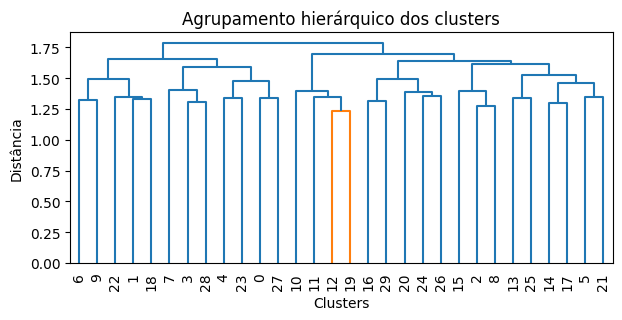

{1: [6, 9], 2: [1, 18, 22], 3: [3, 28], 4: [7], 5: [4, 23], 6: [0, 27], 7: [11, 12, 19], 8: [10], 9: [16, 29], 10: [20, 24, 26], 11: [2, 8], 12: [15], 13: [13, 25], 14: [14, 17], 15: [5, 21]}


In [19]:
centroides = prot.cpu()
dist_matrix = squareform(pdist(centroides, metric='euclidean'))

dist_matrix = pd.DataFrame(
    dist_matrix,
    index=range(prot.shape[0]),
    columns=range(prot.shape[0])
)

mask = np.eye(len(dist_matrix), dtype=bool)
dist_matrix_no_diag = dist_matrix.copy()
dist_matrix_no_diag.values[mask] = np.nan

fig = go.Figure(data=go.Heatmap(
    z=dist_matrix_no_diag.values,
    x=dist_matrix.columns.astype(str),
    y=dist_matrix.index.astype(str),
    colorscale='Viridis',
    colorbar=dict(title='Distância Euclidiana'),
    hovertemplate='Cluster X: %{x}<br>Cluster Y: %{y}<br>Distância: %{z:.2f}<extra></extra>'
))

fig.update_layout(
    title='Matriz de Distâncias entre Centróides (sem diagonal)',
    xaxis_title='Cluster',
    yaxis_title='Cluster',
    width=600,
    height=500
)

fig.show()

Z = linkage(centroides, method='ward')
plt.figure(figsize=(7, 3))
dendrogram(Z, labels=range(centroides.shape[0]), leaf_rotation=90)
plt.title("Agrupamento hierárquico dos clusters")
plt.xlabel("Clusters")
plt.ylabel("Distância")
plt.show()

N_GROUPS = 15
grupo_clusters = fcluster(Z, t=N_GROUPS, criterion='maxclust')
grupos_map = dict(zip(range(centroides.shape[0]), grupo_clusters))
grupos_map = {int(grupo):[i for i in range(centroides.shape[0]) if grupos_map[i] == grupo] for grupo in set(grupo_clusters)}
print(grupos_map)

### Repetir o codigo por grupo

NameError: name 'n_clusters' is not defined

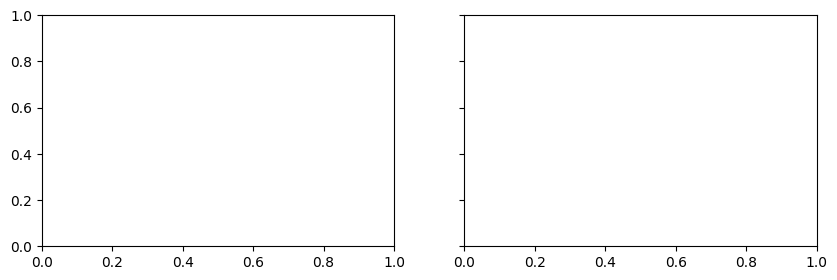

In [ ]:

for group in range(N_GROUPS):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    
    ax_min = axes[0]
    ax_max = axes[1]

    el_nino_clusters = grupos_map[group+1]
    
    possible_colors = sns.color_palette("hsv", n_colors=len(el_nino_clusters))
    
    for c in range(n_clusters):

        color = possible_colors[el_nino_clusters.index(c)] if c in el_nino_clusters else 'gray'
        linewidth = 2 if c in el_nino_clusters else 0.5
        alpha = 1 if c in el_nino_clusters else 0.5

        ax_min.plot(ref_tmin_vals, cluster_tmin_quantiles[c], color=color, linewidth=linewidth, alpha=alpha)
        ax_max.plot(ref_tcluster_probs, cluster_tmax_quantiles[c], color=color, linewidth=linewidth, alpha=alpha)

    # Create legend for el_nino_clusters colors
    handles = []
    labels = []
    for idx, c in enumerate(el_nino_clusters):
        handles.append(plt.Line2D([0], [0], color=possible_colors[idx], lw=2))
        labels.append(f'Cluster {c}')
    ax_min.legend(handles, labels, title='Clusters do Grupo', loc='upper left')
    
    if group == 0:
        ax_min.set_title("QQ Plot TMIN")
        ax_max.set_title("QQ Plot TMAX")
        
    ax_min.set_ylabel(f"Clusters {el_nino_clusters}", fontsize=8)

    plt.tight_layout()
    plt.show()

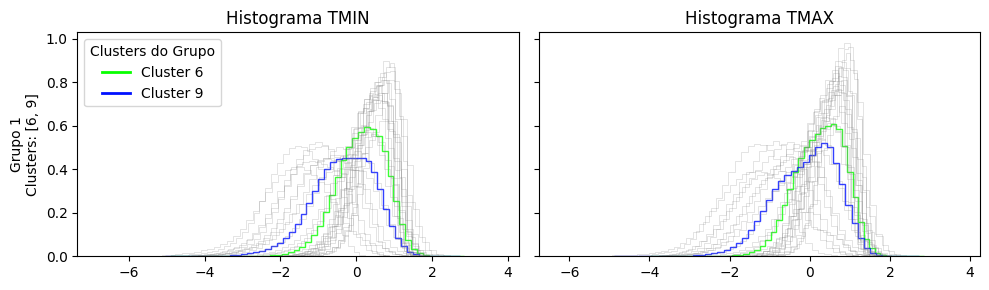

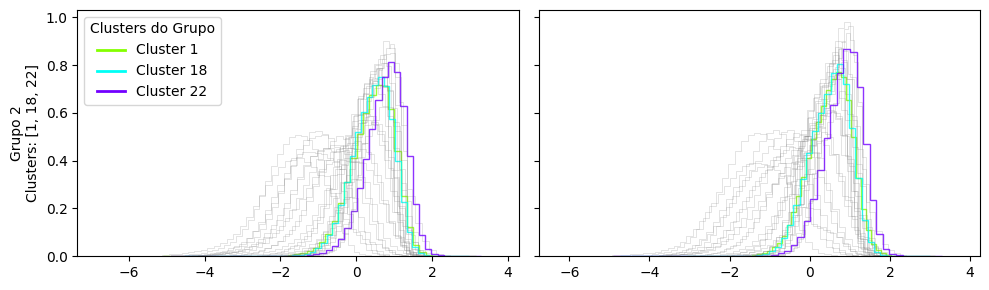

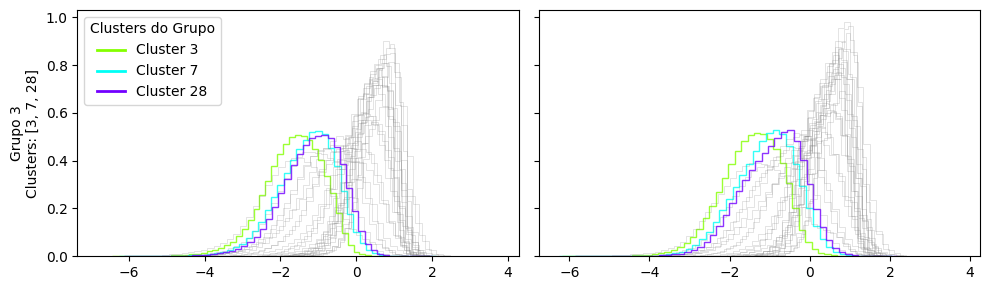

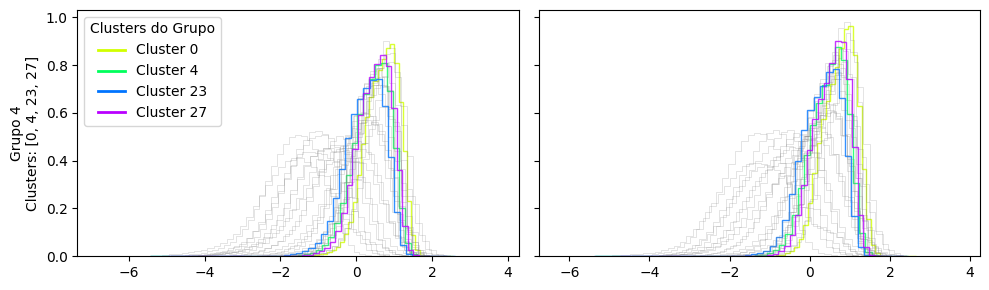

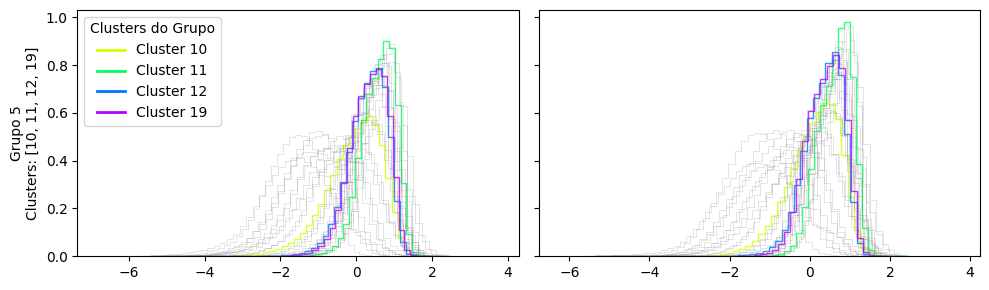

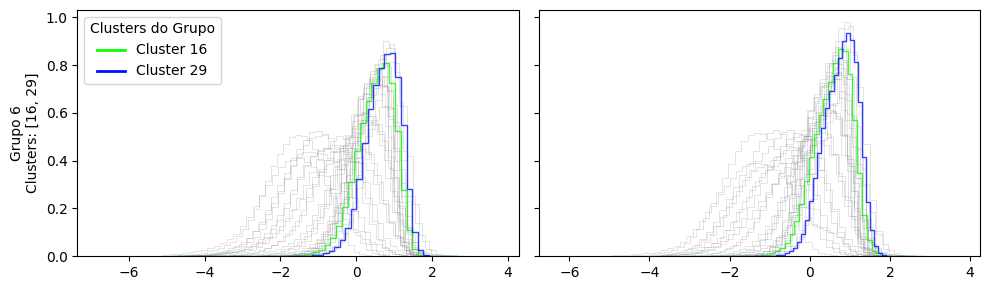

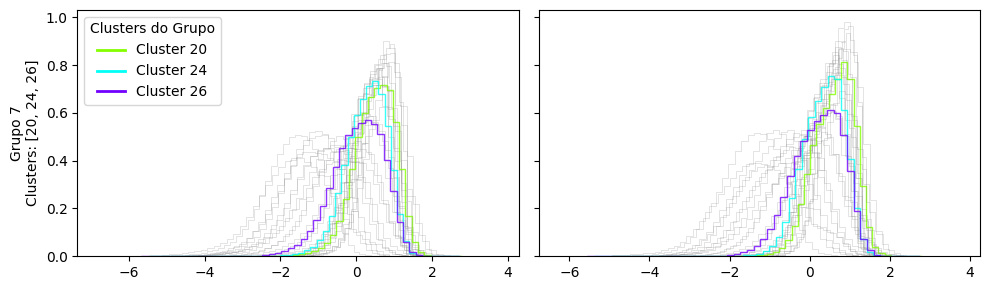

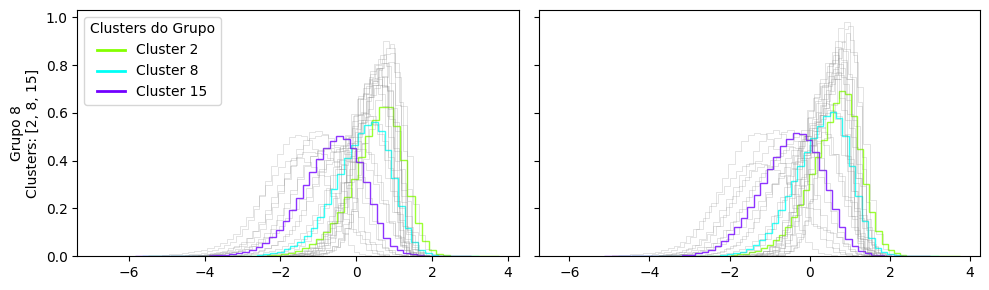

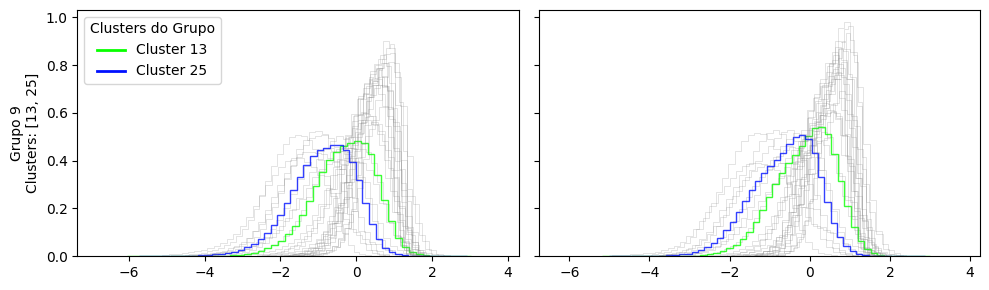

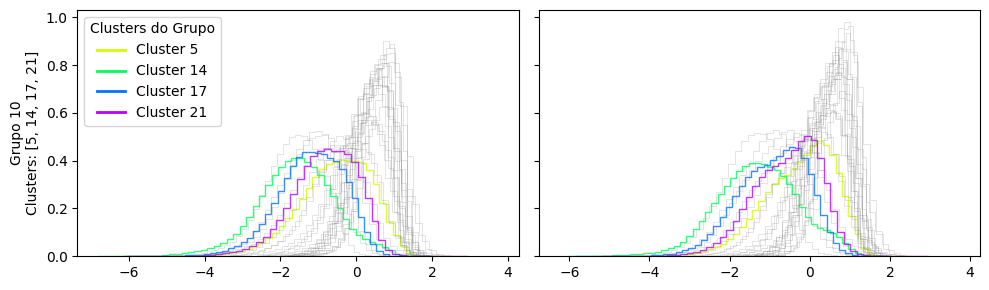

In [ ]:

for group in range(N_GROUPS):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

    ax_min = axes[0]
    ax_max = axes[1]

    el_nino_clusters = grupos_map[group + 1]  # clusters desse grupo
    possible_colors = sns.color_palette("hsv", n_colors=len(el_nino_clusters))  # cores distintas

    for c in range(n_clusters):
        idx = df[df['cluster_id'] == c]['img_id'].values

        color = possible_colors[el_nino_clusters.index(c)] if c in el_nino_clusters else 'gray'
        alpha = 0.8 if c in el_nino_clusters else 0.3
        linewidth = 1 if c in el_nino_clusters else 0.5

        # TMIN
        ax_min.hist(
            tmin[idx].ravel(),
            bins=50,
            density=True,
            histtype='step',
            color=color,
            alpha=alpha,
            linewidth=linewidth
        )

        # TMAX
        ax_max.hist(
            tmax[idx].ravel(),
            bins=50,
            density=True,
            histtype='step',
            color=color,
            alpha=alpha,
            linewidth=linewidth
        )

    # Legenda dos clusters do grupo
    handles = [
        plt.Line2D([0], [0], color=possible_colors[idx], lw=2)
        for idx in range(len(el_nino_clusters))
    ]
    labels = [f'Cluster {c}' for c in el_nino_clusters]
    ax_min.legend(handles, labels, title='Clusters do Grupo', loc='upper left')

    # Títulos e rótulos
    if group == 0:
        ax_min.set_title("Histograma TMIN")
        ax_max.set_title("Histograma TMAX")

    ax_min.set_ylabel(f"Grupo {group+1}\nClusters: {el_nino_clusters}", fontsize=10)

    plt.tight_layout()
    plt.show()
    

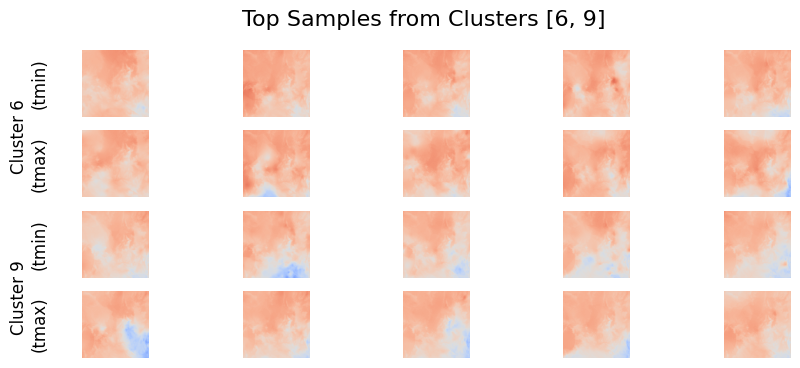

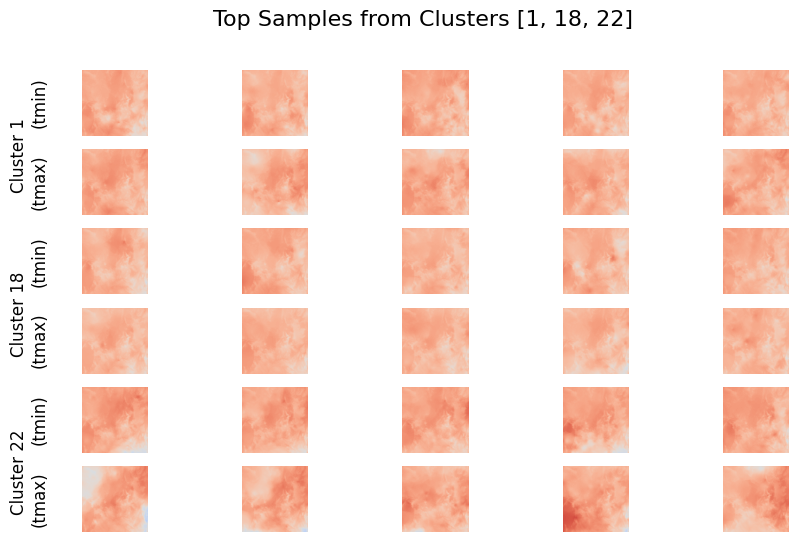

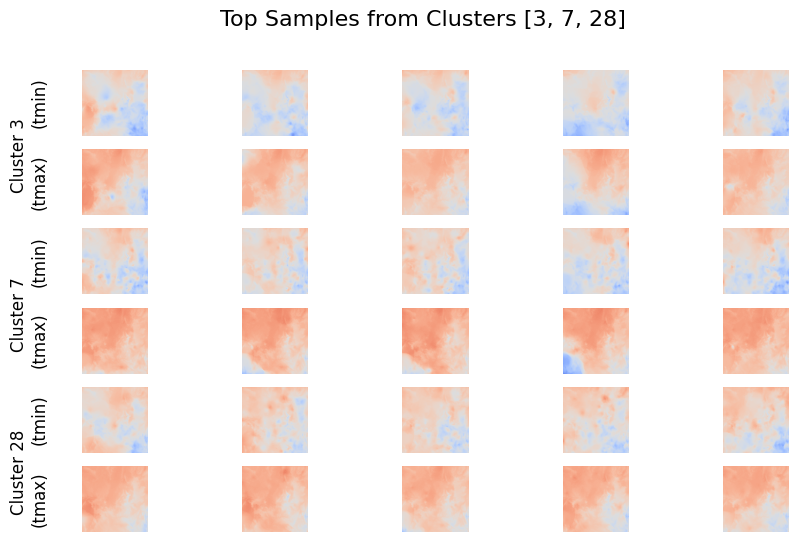

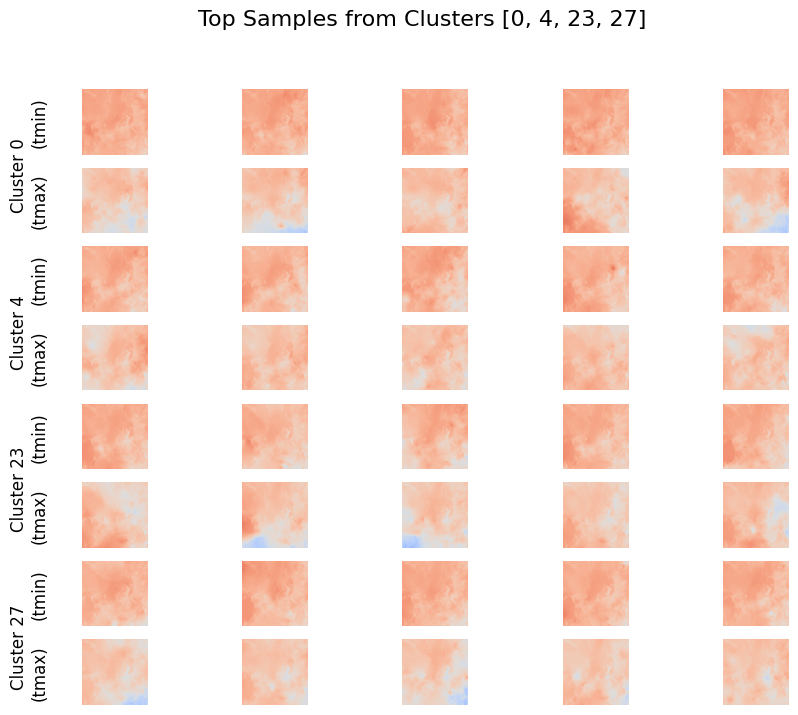

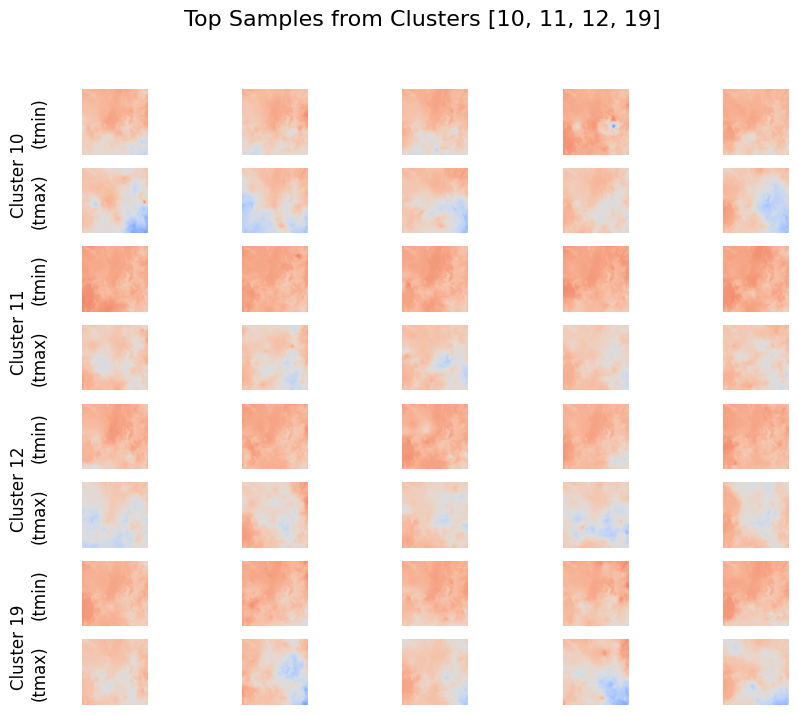

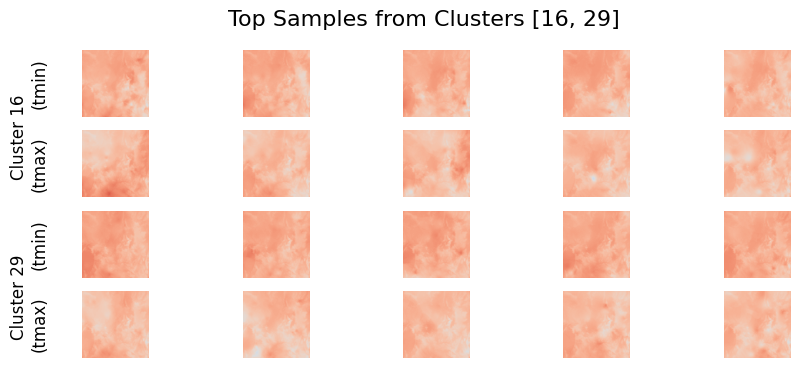

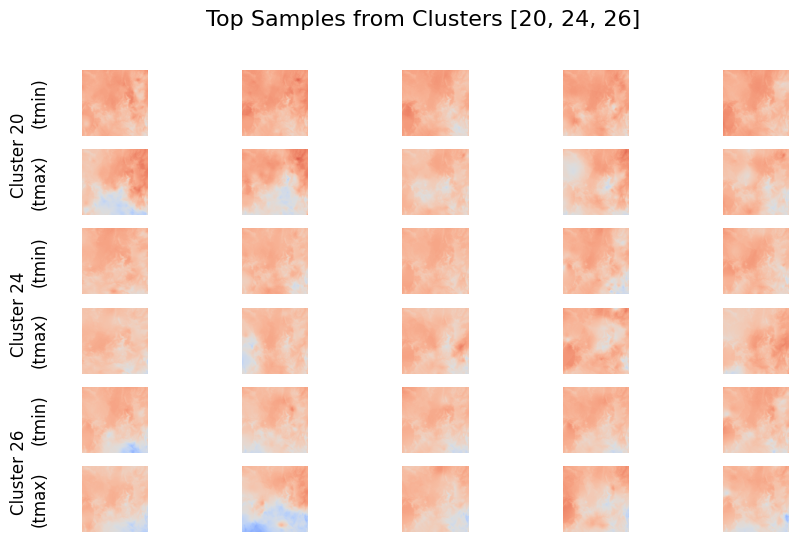

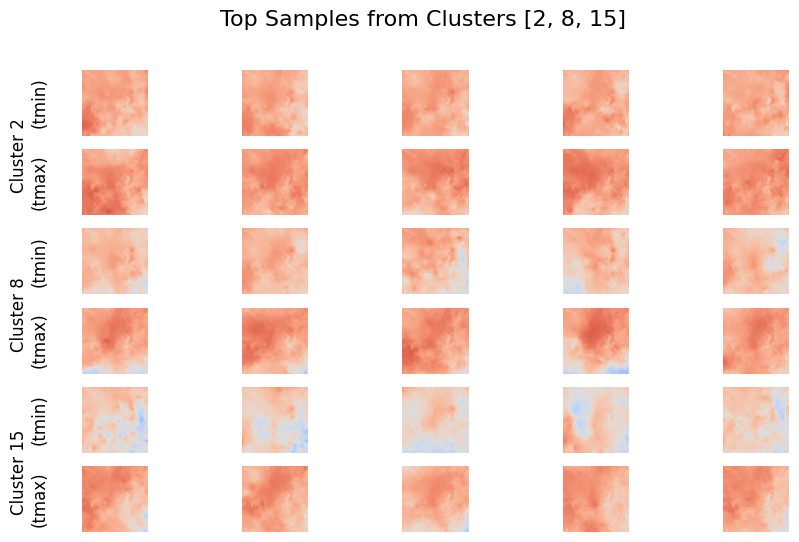

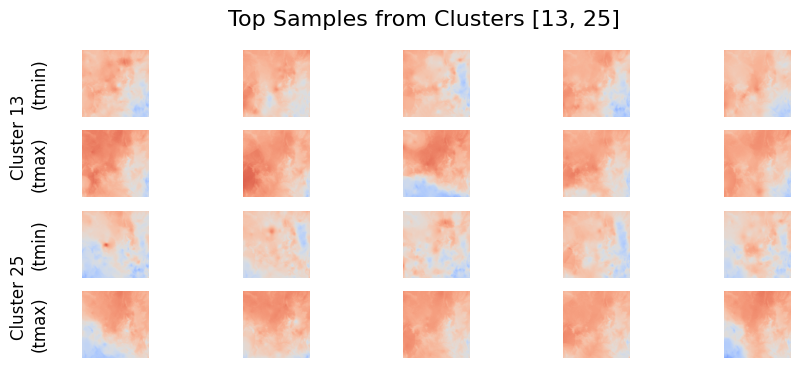

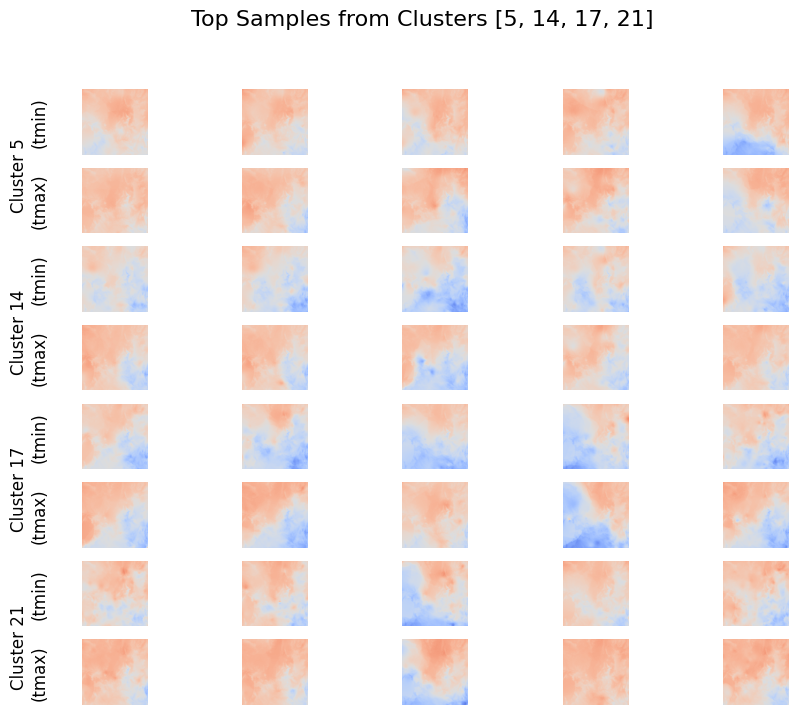

In [173]:
Top_samples = 5

for group in range(N_GROUPS):
    
    grupos = grupos_map[group + 1]  # clusters desse grupo
    
    fig, axes = plt.subplots(len(grupos)*2, Top_samples, figsize=(Top_samples*2,len(grupos)*2)) 
    fig.suptitle(f"Top Samples from Clusters {grupos}", fontsize=16) # Título geral da figura
    
    row_n=0
    
    for c in grupos:
        top_samples = df[df["cluster_id"] == c].nlargest(Top_samples, "cluster_prob")
        
        for j, im_index in enumerate(top_samples.index):
            image_data = combined_dataset[im_index]

            ax_tmin = axes[row_n, j]
            ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
            ax_tmin.axis("off")
            if i == 0: # Adiciona título da coluna apenas na primeira linha
                ax_tmin.set_title(f"Sample {j+1}", fontsize=10)
                
            ax_tmax = axes[row_n+1, j] # Correção do índice para a segunda dimensão
            ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
            ax_tmax.axis("off")
                

        axes[row_n, 0].text(-0.5, -0.3, f"Cluster {c}\n", transform=axes[row_n, 0].transAxes,
                                fontsize=12, va='center', ha='right', rotation=90)

        axes[row_n, 0].text(-0.5, 0.5, f"(tmin)", transform=axes[row_n, 0].transAxes,
                        fontsize=12, va='center', ha='right', rotation=90)

        axes[row_n+1, 0].text(-0.5, 0.5, f"(tmax)", transform=axes[row_n+1, 0].transAxes,
                        fontsize=12, va='center', ha='right', rotation=90)

        row_n += 2
    
    
    fig.show()

## 2. Estações do Ano

In [ ]:
def get_season(date):
    month = date.month
    day = date.day

    # Verão: 21 ou 22 de dezembro a 20 ou 21 de março
    if (month == 12 and day >= 21) or \
       (month == 1 or month == 2) or \
       (month == 3 and day <= 20):
        return 'Verão'
    # Outono: 20 ou 21 de março a 20 ou 21 de junho
    elif (month == 3 and day >= 21) or \
         (month == 4 or month == 5) or \
         (month == 6 and day <= 20):
        return 'Outono'
    # Inverno: 20 ou 21 de junho a 22 ou 23 de setembro
    elif (month == 6 and day >= 21) or \
         (month == 7 or month == 8) or \
         (month == 9 and day <= 22):
        return 'Inverno'
    # Primavera: 22 ou 23 de setembro a 20 ou 21 de dezembro
    else: # (month == 9 and day >= 23) or (month == 10 or month == 11) or (month == 12 and day <= 20)
        return 'Primavera'

# Aplique a função para criar uma nova coluna 'season'
df['season'] = df.index.to_series().apply(get_season)
season_cluster_distribution = pd.crosstab(df['season'], df['cluster_id'])
season_cluster_distribution

max_idx     0    1    2    3    4    5    6    7    8    9   ...   20   21  \
season                                                       ...             
Inverno      0   37  156  533    0  139   89  703  351  147  ...   16  325   
Outono      93   78    0   96  176  543  335   15   37  621  ...  115  477   
Primavera  228  372  444    0  176   59  267    0  341   48  ...  508    4   
Verão      409  262   14    0  481   14  135    0   17   13  ...  194    1   

max_idx     22   23   24   25   26   27   28   29  
season                                             
Inverno      8    3   12  701   68    0  567    1  
Outono      46  187  219   82  431  116  174  107  
Primavera  384  234  247    2  239  193    0  277  
Verão      268  397  357    0   81  468    0  352  

[4 rows x 30 columns]

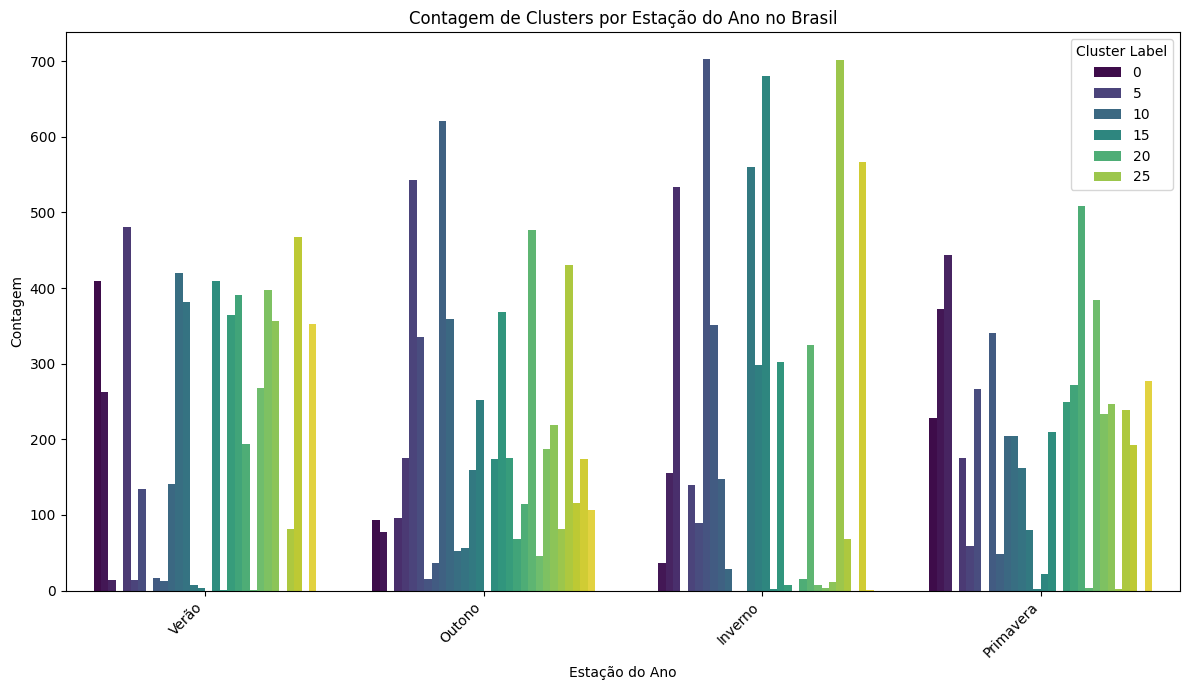

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='season', hue='cluster_id',  palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()

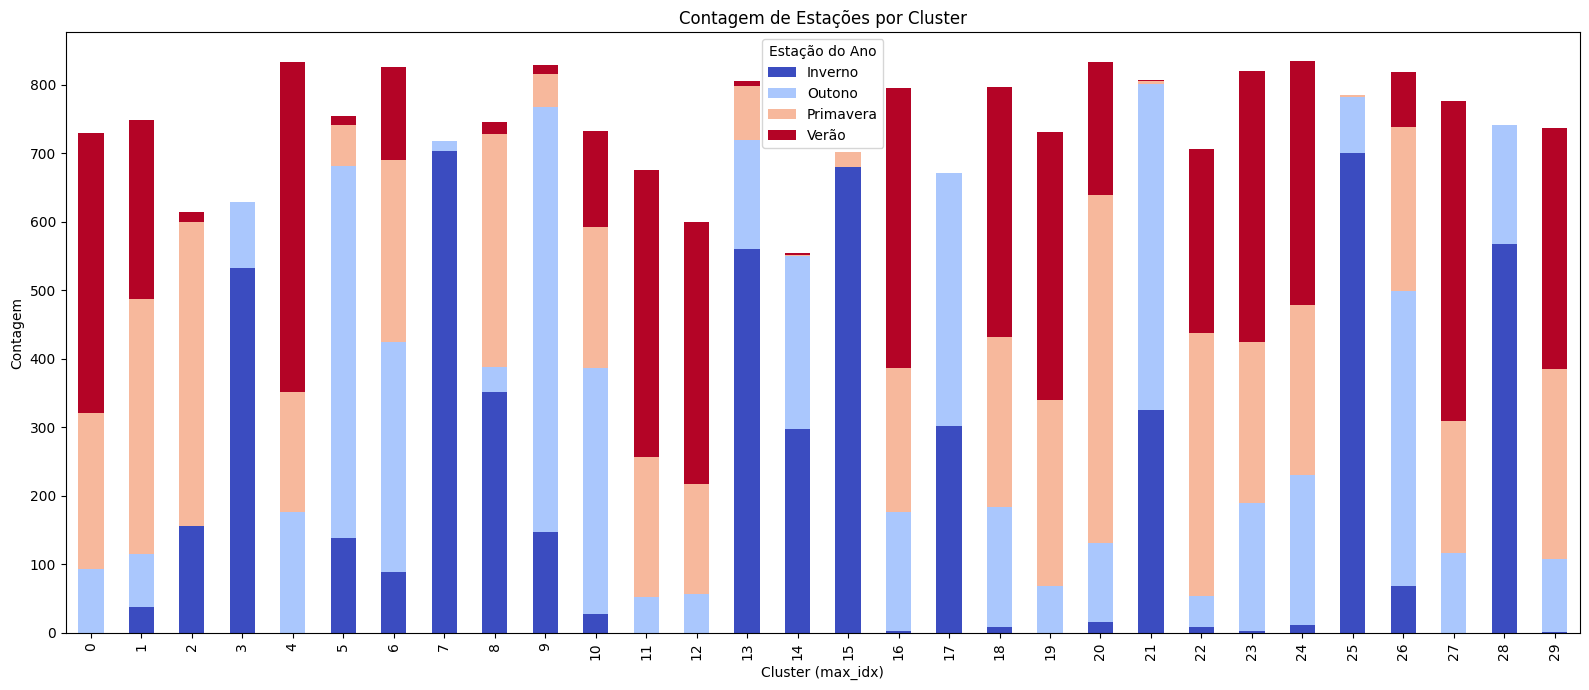

In [ ]:
season_cluster_distribution.T.plot(kind='bar', stacked=True, figsize=(16, 7), colormap='coolwarm')
plt.title('Contagem de Estações por Cluster')
plt.xlabel('Cluster (cluster_id)')
plt.ylabel('Contagem')
plt.legend(title='Estação do Ano')
plt.tight_layout()
plt.show()

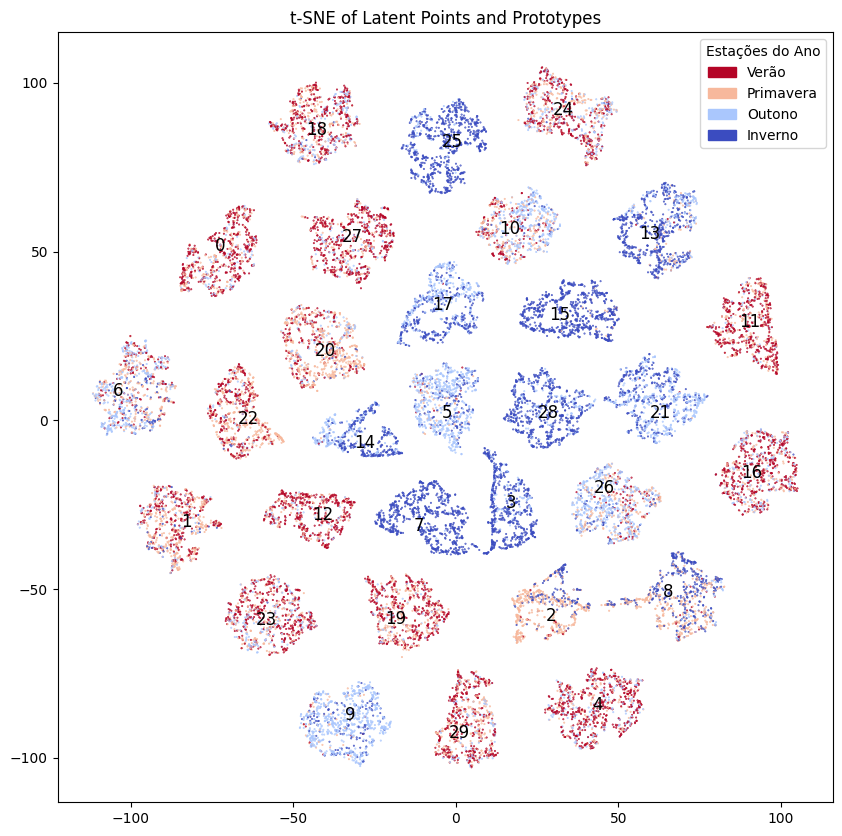

In [117]:
import matplotlib.patches as mpatches

# # Plot the TSNE results
plt.figure(figsize=(10, 10))

cluster_labels = F.argmax(axis=1).cpu().numpy()
estacoes_map = {'Verão':1,'Primavera':2, 'Outono':3, 'Inverno':4}

estacoes_int = df['season'].map(estacoes_map)
plt.scatter(tsne_E[:,0], tsne_E[:,1], c= estacoes_int.values, cmap='coolwarm_r',  s=0.2)

for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

legend_labels = list(estacoes_map.keys())
colors = [plt.cm.coolwarm_r(i/3) for i in range(4)]
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
plt.legend(handles=patches, title='Estações do Ano', loc='best')

# plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

- Mudanças Climáticas

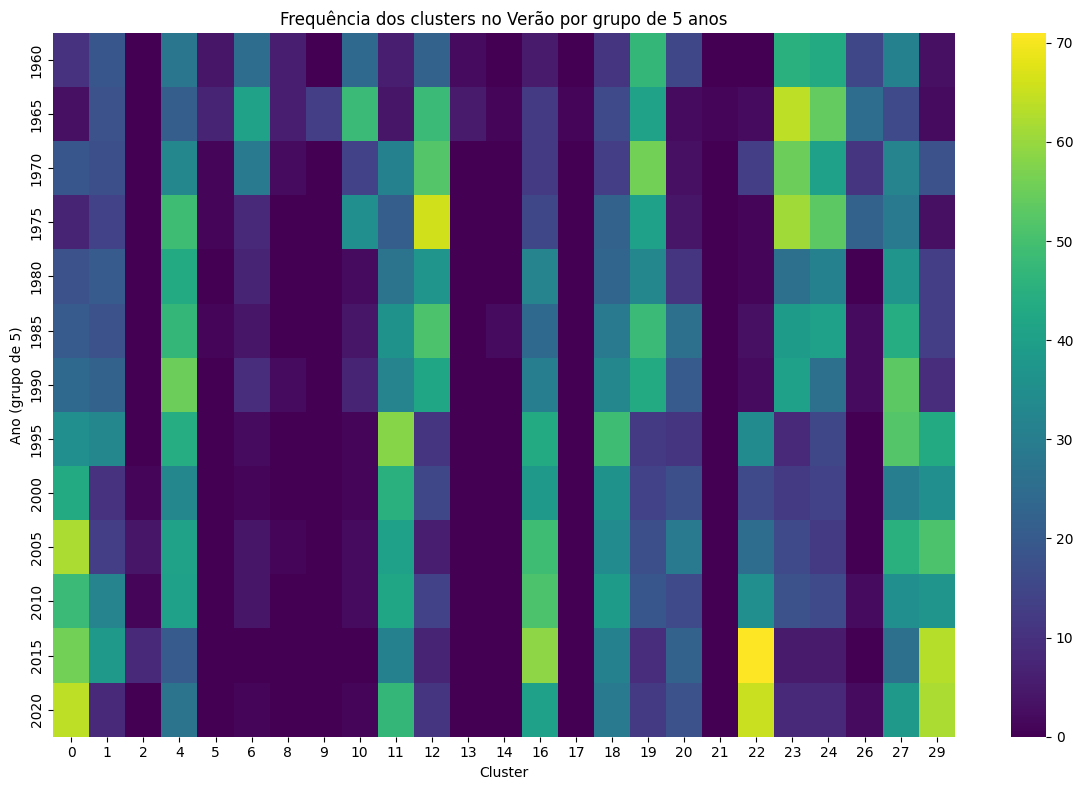

In [ ]:
df_verao = df[df['season'] == 'Verão'].copy()
df_verao['year'] = df_verao.index.year
df_verao['year_group'] = (df_verao['year'] // 5) * 5  # Agrupa de 5 em 5 anos

cluster_verao_ano_group = df_verao.groupby(['year_group', 'cluster_id']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_verao_ano_group, cmap='viridis')
plt.title('Frequência dos clusters no Verão por grupo de 5 anos')
plt.xlabel('Cluster')
plt.ylabel('Ano (grupo de 5)')
plt.tight_layout()
plt.show()

- 0, 22, 29 aumentaram a frequencia
- 1,6,10,12, 19, 23, 24 diminuiram a frequencia

## 3. El Niño

In [174]:
# https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index
oni_index = pd.read_excel('data/oni_index.xlsx')
oni_index.set_index('Year', inplace=True)
oni_index.columns.name='Month'
oni_index.columns = range(1,13)
oni_index= oni_index.unstack().to_frame('ONI')
oni_index['date_period'] = pd.to_datetime(oni_index.index.map(lambda x: f"{x[1]}-{x[0]}-01")).to_period('M')
oni_index.set_index('date_period', inplace=True)

oni_index =oni_index[oni_index.index.year>=1961]

oni_index.loc[oni_index['ONI'] > 0.5,'Label'] = 'El Niño'
oni_index.loc[oni_index['ONI'] < -0.5,'Label'] = 'La Niña'
oni_index.loc[oni_index['ONI'].between(-0.5, 0.5), 'Label'] = 'Neutro'

In [191]:
df['period']= df['date'].dt.to_period('M')
df = df.merge(oni_index[['Label','ONI']], left_on='period', right_index=True, how='left')
df.head()

cluster_id  cluster_prob sample_type       date   period   Label  ONI
0          19      0.885574       train 1961-01-01  1961-01  Neutro  0.0
1          27      0.890362       train 1961-01-02  1961-01  Neutro  0.0
2          19      0.957950       train 1961-01-03  1961-01  Neutro  0.0
3          12      0.972468       train 1961-01-04  1961-01  Neutro  0.0
4          19      0.972903       train 1961-01-05  1961-01  Neutro  0.0

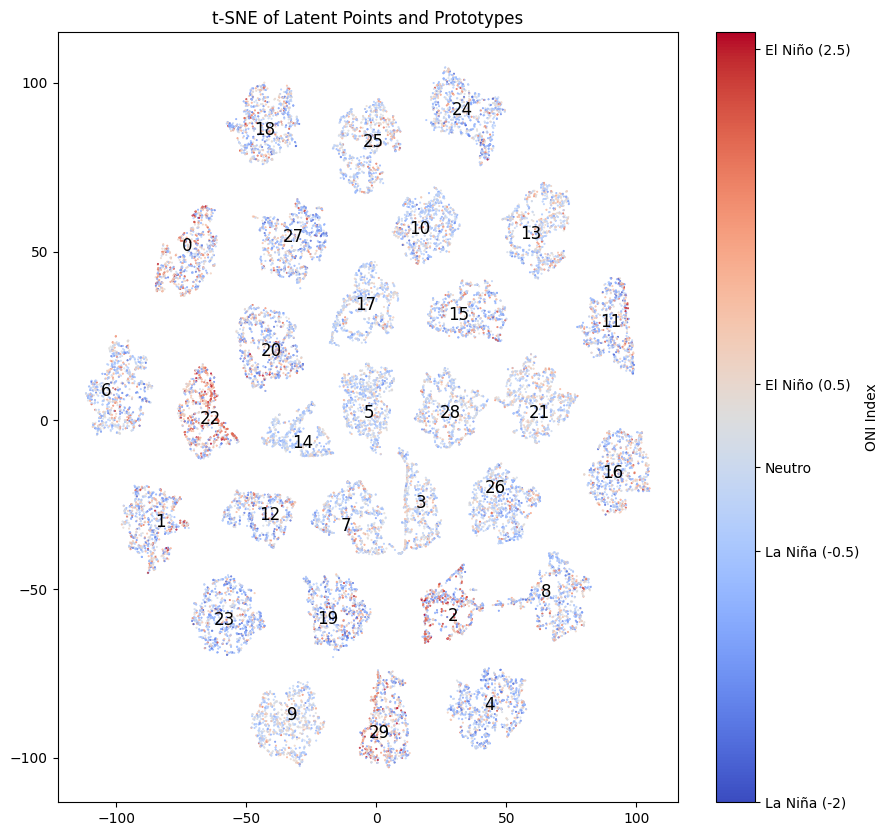

In [197]:
# # Plot the TSNE results
plt.figure(figsize=(10, 10))

cluster_labels = F.argmax(axis=1).cpu().numpy()
plt.scatter(tsne_E[:,0], tsne_E[:,1], c= df[df['sample_type']=='train']['ONI'].values, cmap='coolwarm',  s=0.2)

for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

cbar = plt.colorbar()
cbar.set_label('ONI Index')
cbar.set_ticks([-2, -0.5, 0.5, 2.5, 0])
cbar.set_ticklabels(['La Niña (-2)', 'La Niña (-0.5)', 'El Niño (0.5)', 'El Niño (2.5)', 'Neutro'])

plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

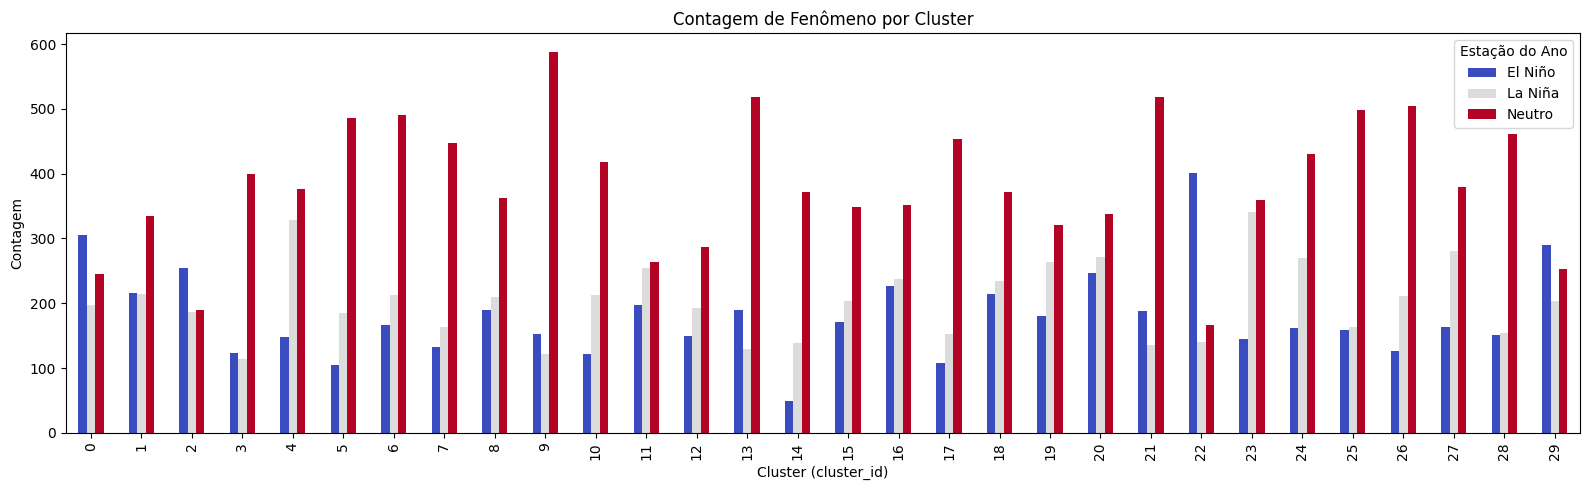

In [198]:
df.groupby(['Label','cluster_id']).size().unstack(level=0).plot(kind='bar', stacked=False, figsize=(16, 5), colormap='coolwarm')
plt.title('Contagem de Fenômeno por Cluster')
plt.xlabel('Cluster (cluster_id)')
plt.ylabel('Contagem')
plt.legend(title='Estação do Ano')
plt.tight_layout()
plt.show()

In [199]:
percent = df.groupby(['Label','cluster_id']).size().to_frame('count').join(df.groupby('Label').size().to_frame('Total fenonemo')).join(df.groupby('cluster_id').size().to_frame('Total cluster'))
percent['percent_cluster'] =( percent['count'] / percent['Total cluster'])*100
percent['percent_fenomeno'] = (percent['count'] / percent['Total fenonemo'])*100
percent.head()

count  Total fenonemo  Total cluster  percent_cluster  \
Label   cluster_id                                                          
El Niño 0             306            5434            749        40.854473   
        1             216            5434            764        28.272251   
        2             254            5434            630        40.317460   
        3             123            5434            637        19.309262   
        4             148            5434            853        17.350528   

                    percent_fenomeno  
Label   cluster_id                    
El Niño 0                   5.631211  
        1                   3.974972  
        2                   4.674273  
        3                   2.263526  
        4                   2.723592

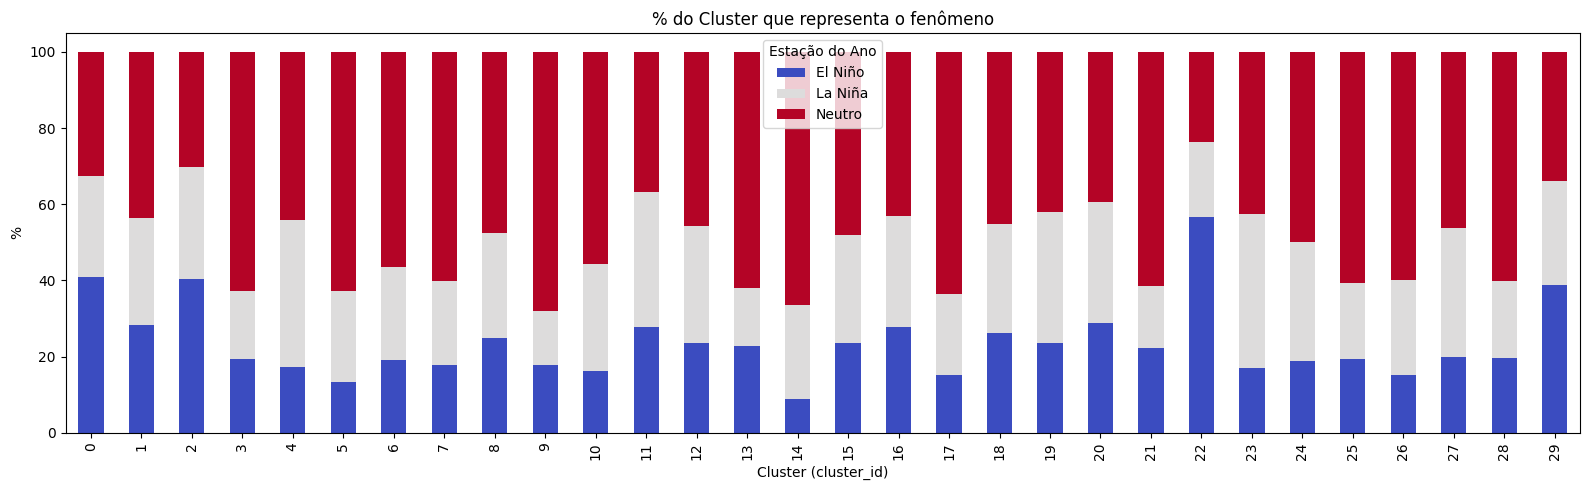

In [200]:
percent['percent_cluster'].unstack(level=0).plot(kind='bar', stacked=True, figsize=(16, 5), colormap='coolwarm')
plt.title('% do Cluster que representa o fenômeno')
plt.xlabel('Cluster (cluster_id)')
plt.ylabel('%')
plt.legend(title='Estação do Ano')
plt.tight_layout()
plt.show()

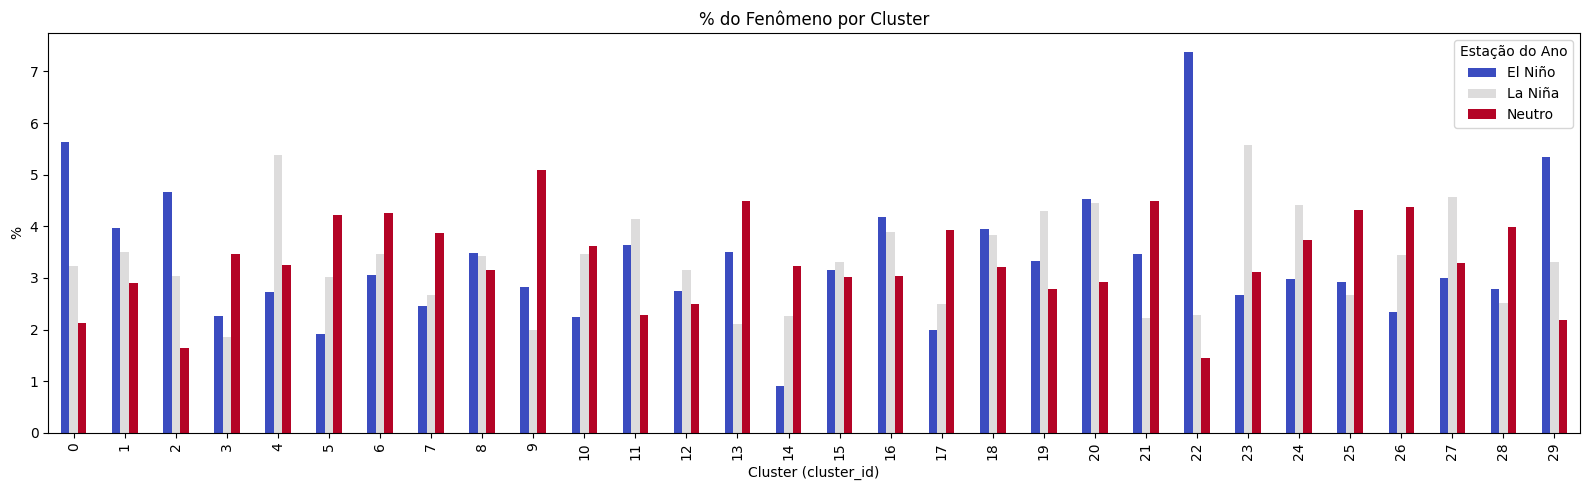

In [201]:
percent['percent_fenomeno'].unstack(level=0).plot(kind='bar', stacked=False, figsize=(16, 5), colormap='coolwarm')
plt.title('% do Fenômeno por Cluster')
plt.xlabel('Cluster (cluster_id)')
plt.ylabel('%')
plt.legend(title='Estação do Ano')
plt.tight_layout()
plt.show()

- Comparando os cluster em que mais de 40% das amostras são durante o el nino

In [217]:
p_cluster = percent['percent_cluster'].unstack(level=0)
display(p_cluster[p_cluster["El Niño"]>40])
el_nino_clusters = list(p_cluster[p_cluster["El Niño"]>40].index)

Label         El Niño    La Niña     Neutro
cluster_id                                 
0           40.854473  26.435247  32.710280
2           40.317460  29.523810  30.158730
22          56.638418  19.774011  23.587571

In [218]:
for cluster in el_nino_clusters:
    print(f"Cluster {cluster} - El Niño")
    print(df[(df['cluster_id']==cluster)&(df['Label']=='El Niño')]['cluster_prob'].describe(),'\n')
    
    print(f"Cluster {cluster} - not El Niño")
    print(df[(df['cluster_id']==cluster)&(df['Label']!='El Niño')]['cluster_prob'].describe(),'\n')

Cluster 0 - El Niño
count    306.000000
mean       0.927872
std        0.052576
min        0.650908
25%        0.905235
50%        0.938795
75%        0.965741
max        0.993055
Name: cluster_prob, dtype: float64 

Cluster 0 - not El Niño
count    443.000000
mean       0.923680
std        0.056667
min        0.645160
25%        0.893822
50%        0.938911
75%        0.968247
max        0.994740
Name: cluster_prob, dtype: float64 

Cluster 2 - El Niño
count    254.000000
mean       0.951955
std        0.052084
min        0.726223
25%        0.934416
50%        0.976290
75%        0.984555
max        0.994219
Name: cluster_prob, dtype: float64 

Cluster 2 - not El Niño
count    376.000000
mean       0.949920
std        0.054171
min        0.711772
25%        0.934116
50%        0.973751
75%        0.985552
max        0.995117
Name: cluster_prob, dtype: float64 

Cluster 22 - El Niño
count    401.000000
mean       0.941601
std        0.048106
min        0.738137
25%        0.922442
50%

-> padrões são bastante consistentes. a confiança é alta em ambs os casos para todos os 3 clusters


Há padrões espaciais característicos nas temperaturas associadas aos clusters "El Niño"?
Comparar a distribuição dos 3 (histogramas e samples).


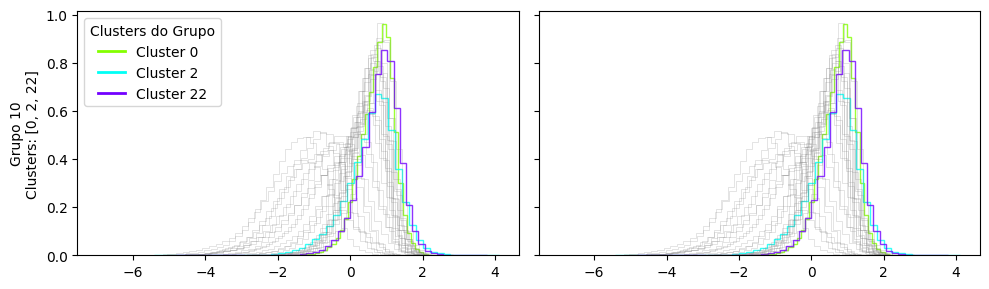

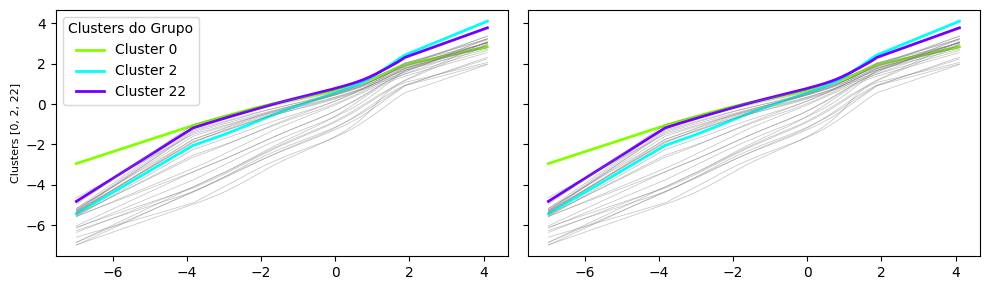

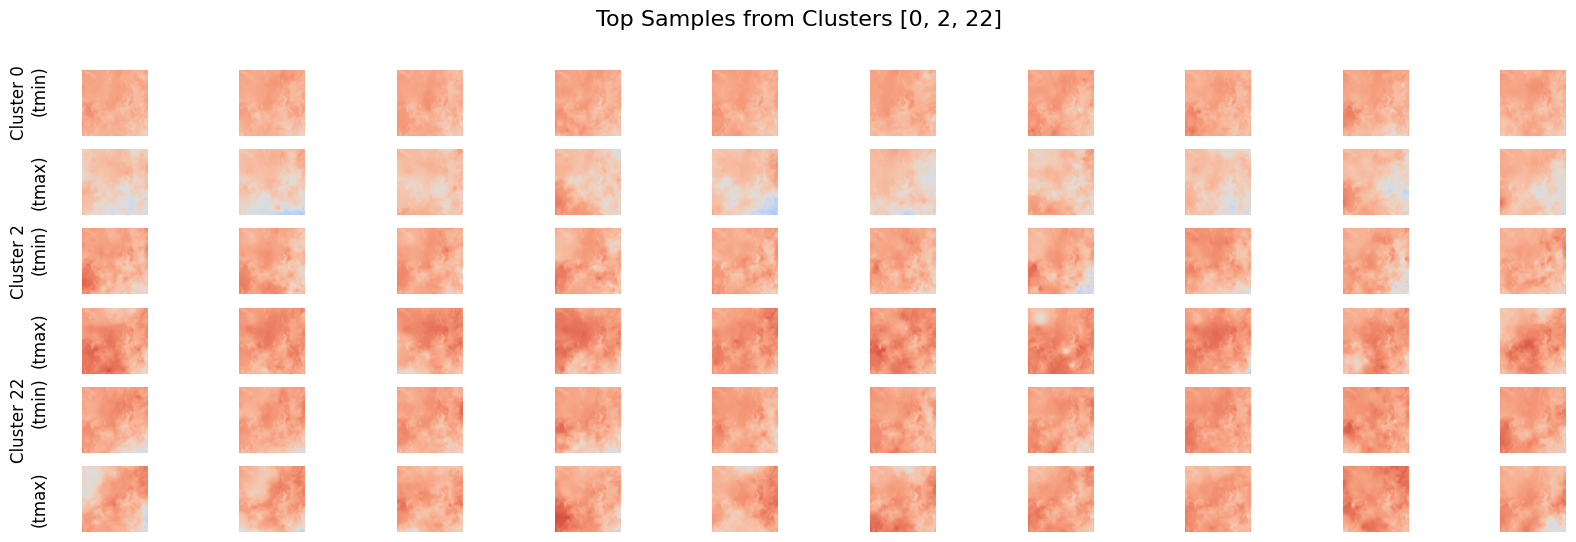

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

ax_min = axes[0]
ax_max = axes[1]


possible_colors = sns.color_palette("hsv", n_colors=len(el_nino_clusters))  # cores distintas

for c in range(n_clusters):
    idx = df[df['cluster_id'] == c].index.values

    color = possible_colors[el_nino_clusters.index(c)] if c in el_nino_clusters else 'gray'
    alpha = 0.8 if c in el_nino_clusters else 0.3
    linewidth = 1 if c in el_nino_clusters else 0.5

    # TMIN
    ax_min.hist(
        tmin[idx].ravel(),
        bins=50,
        density=True,
        histtype='step',
        color=color,
        alpha=alpha,
        linewidth=linewidth
    )

    # TMAX
    ax_max.hist(
        tmax[idx].ravel(),
        bins=50,
        density=True,
        histtype='step',
        color=color,
        alpha=alpha,
        linewidth=linewidth
    )

# Legenda dos clusters do grupo
handles = [
    plt.Line2D([0], [0], color=possible_colors[idx], lw=2)
    for idx in range(len(el_nino_clusters))
]
labels = [f'Cluster {c}' for c in el_nino_clusters]
ax_min.legend(handles, labels, title='Clusters do Grupo', loc='upper left')

# Títulos e rótulos
if group == 0:
    ax_min.set_title("Histograma TMIN")
    ax_max.set_title("Histograma TMAX")

ax_min.set_ylabel(f"Grupo {group+1}\nClusters: {el_nino_clusters}", fontsize=10)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

ax_min = axes[0]
ax_max = axes[1]

for c in range(n_clusters):

    color = possible_colors[el_nino_clusters.index(c)] if c in el_nino_clusters else 'gray'
    linewidth = 2 if c in el_nino_clusters else 0.5
    alpha = 1 if c in el_nino_clusters else 0.5

    ax_min.plot(ref_tmin_vals, cluster_tmin_quantiles[c], color=color, linewidth=linewidth, alpha=alpha)
    ax_max.plot(ref_tcluster_probs, cluster_tmax_quantiles[c], color=color, linewidth=linewidth, alpha=alpha)

# Create legend for el_nino_clusters colors
handles = []
labels = []
for idx, c in enumerate(el_nino_clusters):
    handles.append(plt.Line2D([0], [0], color=possible_colors[idx], lw=2))
    labels.append(f'Cluster {c}')
ax_min.legend(handles, labels, title='Clusters do Grupo', loc='upper left')

if group == 0:
    ax_min.set_title("QQ Plot TMIN")
    ax_max.set_title("QQ Plot TMAX")
    
ax_min.set_ylabel(f"Clusters {el_nino_clusters}", fontsize=8)

plt.tight_layout()
plt.show()

Top_samples = 10
fig, axes = plt.subplots(len(el_nino_clusters)*2, Top_samples, figsize=(Top_samples*2,len(el_nino_clusters)*2)) 
fig.suptitle(f"Top Samples from Clusters {el_nino_clusters}", fontsize=16) # Título geral da figura

row_n=0

for c in el_nino_clusters:
    top_samples = df[df["cluster_id"] == c].nlargest(Top_samples, "cluster_prob")
    
    for j, im_index in enumerate(top_samples.index):
        image_data = combined_dataset[im_index]

        ax_tmin = axes[row_n, j]
        ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
        ax_tmin.axis("off")
        if i == 0: # Adiciona título da coluna apenas na primeira linha
            ax_tmin.set_title(f"Sample {j+1}", fontsize=10)
            
        ax_tmax = axes[row_n+1, j] # Correção do índice para a segunda dimensão
        ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
        ax_tmax.axis("off")
    

    axes[row_n, 0].text(-0.5, 0.5, f"Cluster {c}\n(tmin)", transform=axes[row_n, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)

    axes[row_n+1, 0].text(-0.5, 0.5, f"(tmax)", transform=axes[row_n+1, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)

    row_n += 2

fig.show()

Há sazonalidade nos clusters com alta associação ao El Niño?

In [222]:
df

cluster_id  cluster_prob sample_type       date   period    Label  ONI  \
0              19      0.885574       train 1961-01-01  1961-01   Neutro  0.0   
1              27      0.890362       train 1961-01-02  1961-01   Neutro  0.0   
2              19      0.957950       train 1961-01-03  1961-01   Neutro  0.0   
3              12      0.972468       train 1961-01-04  1961-01   Neutro  0.0   
4              19      0.972903       train 1961-01-05  1961-01   Neutro  0.0   
...           ...           ...         ...        ...      ...      ...  ...   
23085          22      0.967713       train 2024-03-16  2024-03  El Niño  1.1   
23086          22      0.973696       train 2024-03-17  2024-03  El Niño  1.1   
23087          22      0.990760       train 2024-03-18  2024-03  El Niño  1.1   
23088          22      0.980670       train 2024-03-19  2024-03  El Niño  1.1   
23089          29      0.939077       train 2024-03-20  2024-03  El Niño  1.1   

       month  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
23085      3  
23086      3  
23087      3  
23088      3  
23089      3  

[23090 rows x 8 columns]

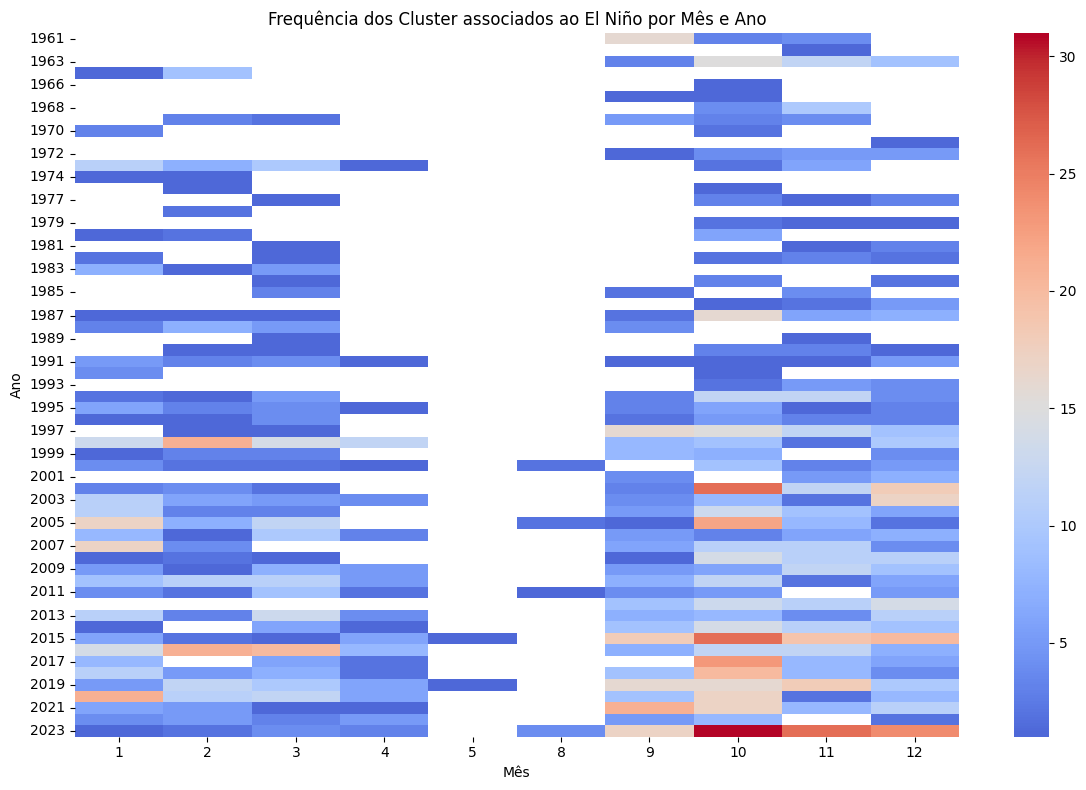

In [223]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
elnino_agrupado = df[df['cluster_id'].isin([0,2,22])].groupby(['year','month']).size().unstack().drop(2024)

plt.figure(figsize=(12, 8))
sns.heatmap(elnino_agrupado, cmap='coolwarm',vmin=elnino_agrupado.min().min(),vmax=elnino_agrupado.max().max(),center=15)
plt.title('Frequência dos Cluster associados ao El Niño por Mês e Ano')
plt.xlabel('Mês')
plt.ylabel('Ano')
plt.tight_layout()
plt.show()

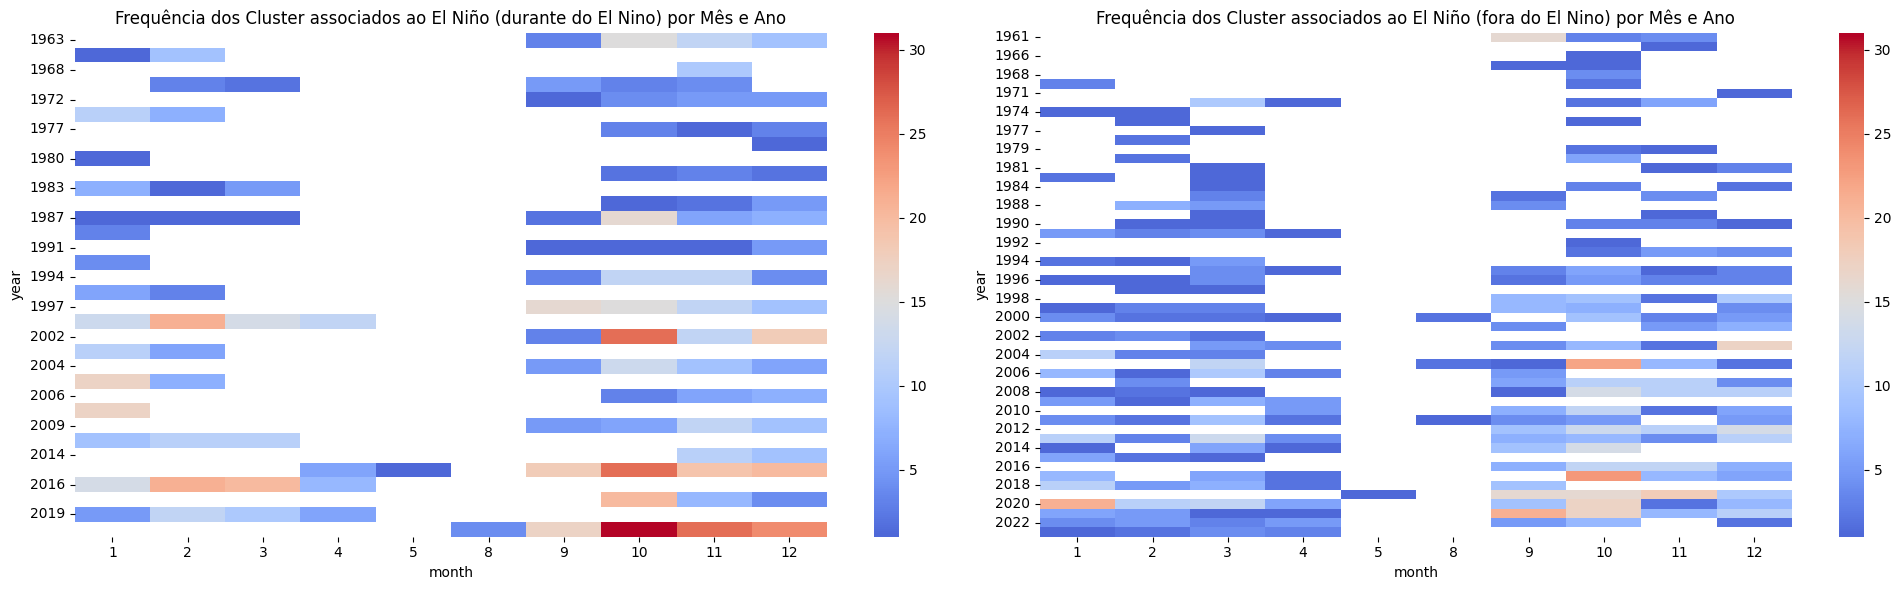

In [224]:

durante_el_nino = df[(df['cluster_id'].isin([0,2,22])) & (df['Label']=='El Niño')]\
    .groupby(['year','month']).size().unstack().drop(2024, errors='ignore')
    
fora_el_nino = df[(df['cluster_id'].isin([0,2,22])) & (df['Label']!='El Niño')]\
    .groupby(['year','month']).size().unstack().drop(2024, errors='ignore')


fig, ax = plt.subplots(1,2,figsize=(20, 6))

sns.heatmap(durante_el_nino, cmap='coolwarm',vmin=elnino_agrupado.min().min(),vmax=elnino_agrupado.max().max(),center=15,ax=ax[0])
ax[0].set_title('Frequência dos Cluster associados ao El Niño (durante do El Nino) por Mês e Ano')

sns.heatmap(fora_el_nino, cmap='coolwarm',vmin=elnino_agrupado.min().min(),vmax=elnino_agrupado.max().max(),center=15,ax=ax[1])
ax[1].set_title('Frequência dos Cluster associados ao El Niño (fora do El Nino) por Mês e Ano')


plt.tight_layout()
plt.show()

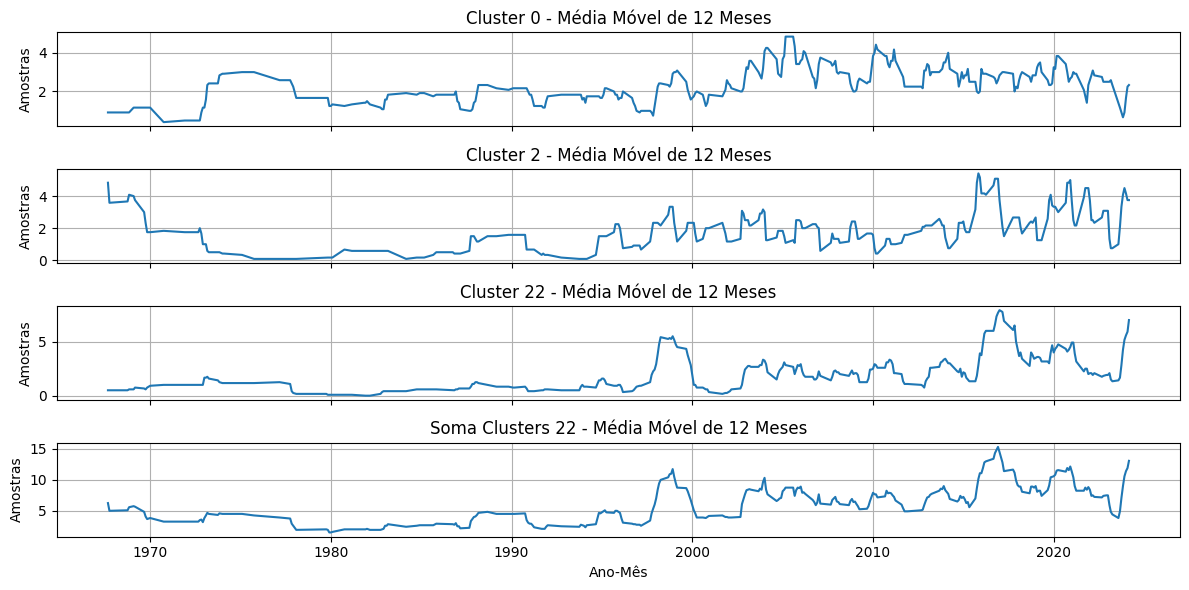

In [225]:
freq = df[df['cluster_id'].isin([0,2,22])]\
    .groupby(['period', 'cluster_id']).size()\
    .unstack(fill_value=0)
    

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

for i, cluster in enumerate([0,2,22]):
    ax = axes[i]
    # ax.plot(freq.index.to_timestamp(), freq[cluster],)
    ax.plot(freq.index.to_timestamp(), freq[cluster].rolling(12).mean())
    ax.set_title(f'Cluster {cluster} - Média Móvel de 12 Meses')
    ax.set_ylabel('Amostras')
    ax.grid(True)

ax = axes[3]
ax.plot(freq.index.to_timestamp(),freq.sum(axis=1).rolling(12).mean())
ax.set_title(f'Soma Clusters {cluster} - Média Móvel de 12 Meses')
ax.set_ylabel('Amostras')
ax.grid(True)

axes[-1].set_xlabel('Ano-Mês')
plt.tight_layout()
plt.show()

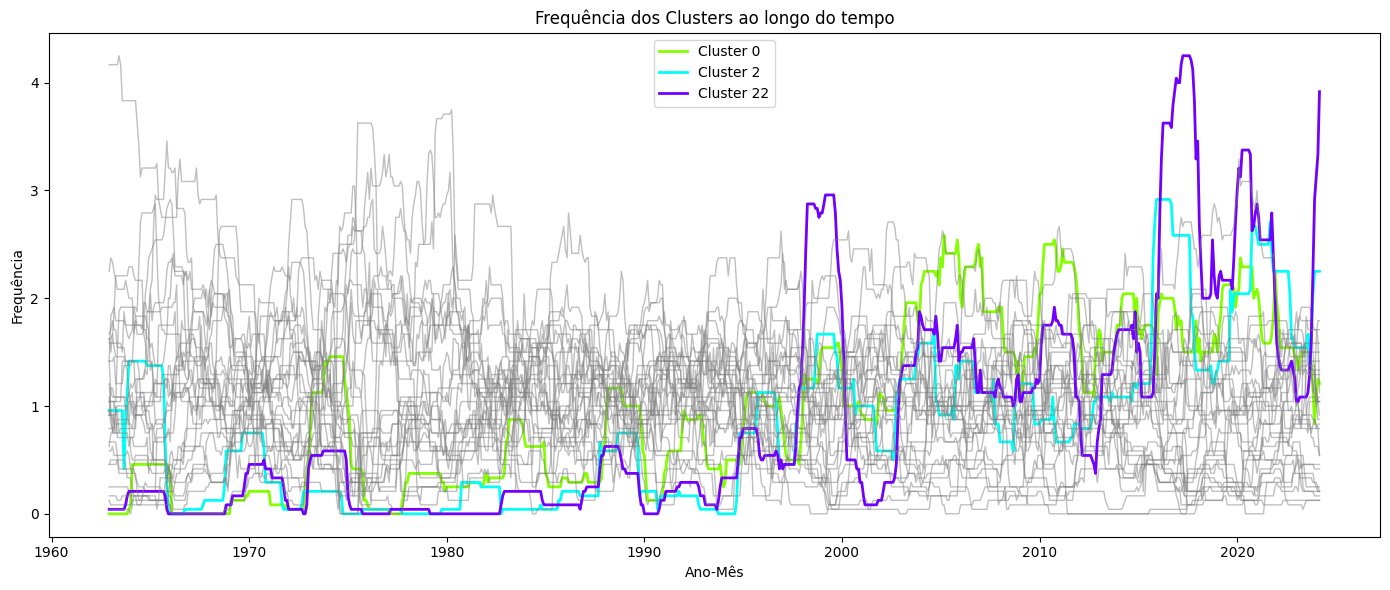

In [226]:
freq = df\
    .groupby(['period', 'cluster_id']).size()\
    .unstack(fill_value=0)
    
# Plotar as frequências de todos os clusters em cinza e destacar 0, 2, 22
highlight_clusters = [0, 2, 22]
colors = sns.color_palette("hsv", n_colors=len(highlight_clusters))

plt.figure(figsize=(14, 6))
for cluster in freq.columns:
    if cluster in highlight_clusters:
        color = colors[highlight_clusters.index(cluster)]
        plt.plot(freq.index.to_timestamp(), freq[cluster].rolling(24).mean(), label=f'Cluster {cluster}', color=color, linewidth=2)
    else:
        plt.plot(freq.index.to_timestamp(), freq[cluster].rolling(24).mean(), color='gray', alpha=0.5, linewidth=1)

plt.title('Frequência dos Clusters ao longo do tempo')
plt.xlabel('Ano-Mês')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Média Movel de 12 Meses dos Clusters (0,2,22) vs clusters semelhantes (1,18,8)gray e (4,23,27)black')

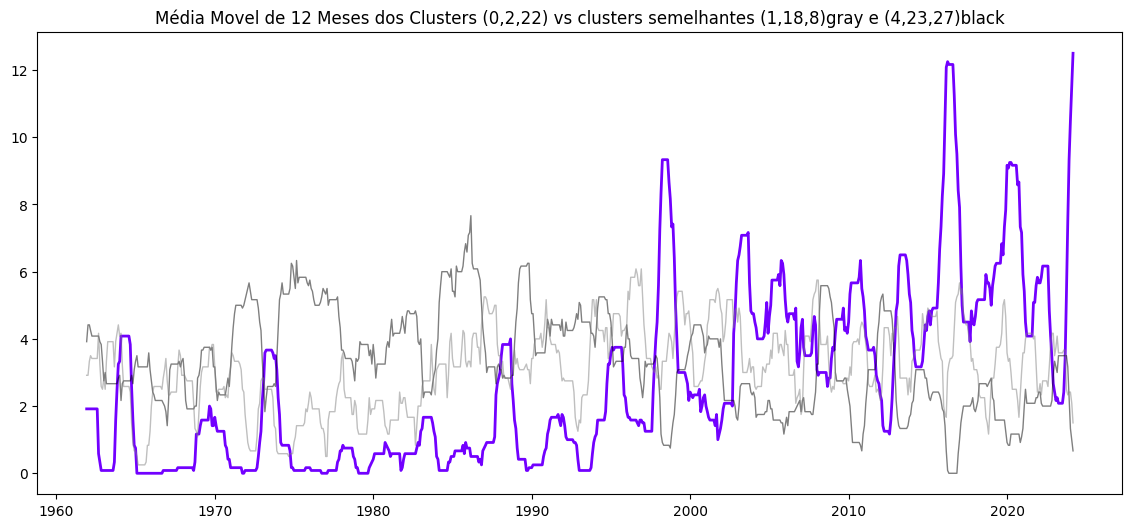

In [227]:
freq = df\
    .groupby(['period', 'cluster_id']).size()\
    .unstack(fill_value=0)
    
el_nino = freq[[0,2,22]] .sum(axis=1)
others = freq[[1,18,8]].sum(axis=1)
others2 = freq[[4,23,27]].sum(axis=1)

# # Plotar as frequências de todos os clusters em cinza e destacar 0, 2, 22
# highlight_clusters = [0, 2, 22]
# colors = sns.color_palette("hsv", n_colors=len(highlight_clusters))

plt.figure(figsize=(14, 6))

plt.plot(freq.index.to_timestamp(), el_nino.rolling(12).mean(), label=f'Clusters (0,2,22)', color=color, linewidth=2)
plt.plot(freq.index.to_timestamp(), others2.rolling(12).mean(), color='black', alpha=0.5, linewidth=1)
plt.plot(freq.index.to_timestamp(), others.rolling(12).mean(), color='gray', alpha=0.5, linewidth=1)

plt.title('Média Movel de 12 Meses dos Clusters (0,2,22) vs clusters semelhantes (1,18,8)gray e (4,23,27)black')
# plt.xlabel('Ano-Mês')
# plt.ylabel('Frequência')
# plt.legend()
# plt.tight_layout()
# plt.show()

Os valores do índice ONI das amostras desses clusters são significativamente maiores?

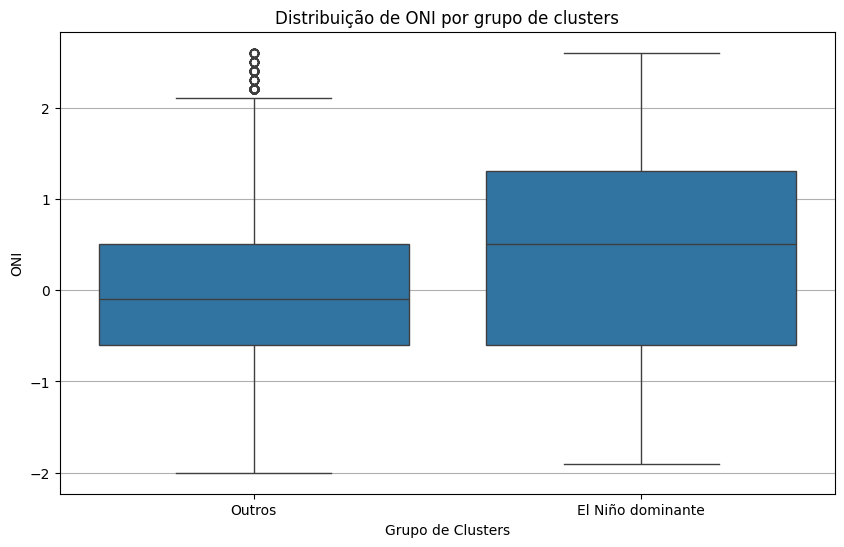

In [228]:

top_clusters = [0,2,22]

df['grupo'] = df['cluster_id'].apply(lambda x: 'El Niño dominante' if x in top_clusters else 'Outros')

# 3. Boxplot do ONI
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='grupo', y='ONI')
plt.title('Distribuição de ONI por grupo de clusters')
plt.ylabel('ONI')
plt.xlabel('Grupo de Clusters')
plt.grid(axis='y')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


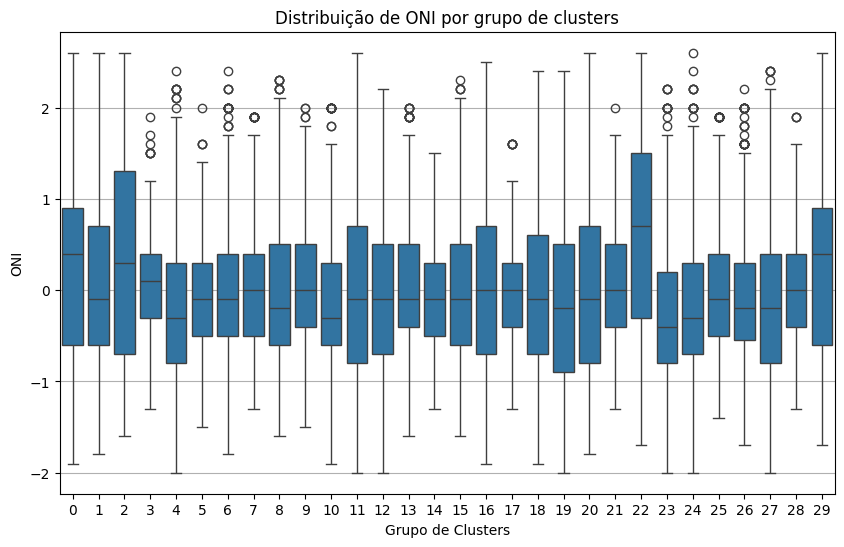

In [229]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster_id', y='ONI',)
plt.title('Distribuição de ONI por grupo de clusters')
plt.ylabel('ONI')
plt.xlabel('Grupo de Clusters')
plt.grid(axis='y')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='cluster_id', ylabel='ONI'>

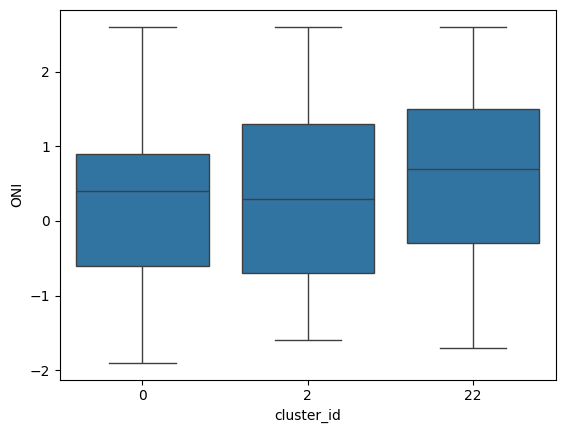

In [230]:
sns.boxplot(data=df[df['cluster_id'].isin(top_clusters)], x='cluster_id', y='ONI')

In [ ]:
from scipy.stats import mannwhitneyu

oni_selecionados =  df[df['cluster_id'].isin(top_clusters)]['ONI']
oni_outros =  df[~df['cluster_id'].isin(top_clusters)]['ONI']

stat, p_value = mannwhitneyu(oni_selecionados, oni_outros, alternative='greater')
print(f"Mann-Whitney U test: stat={stat:.2f}, p={p_value:.4f} ({p_value< 0.05})")

Mann-Whitney U test: stat=26280543.50, p=0.0000 (True)


In [327]:
from scipy.stats import ks_2samp

stat, p_value = ks_2samp(oni_selecionados, oni_outros)
print(f"KS test: stat={stat:.2f}, p={p_value:.4f}")

KS test: stat=0.27, p=0.0000


. Há transição entre clusters ao longo do tempo com eventos El Niño?

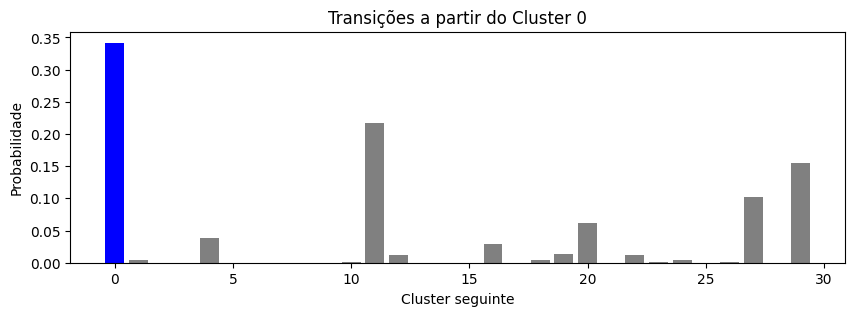

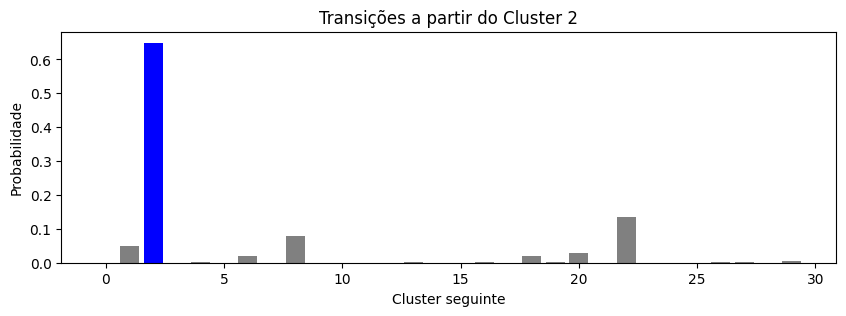

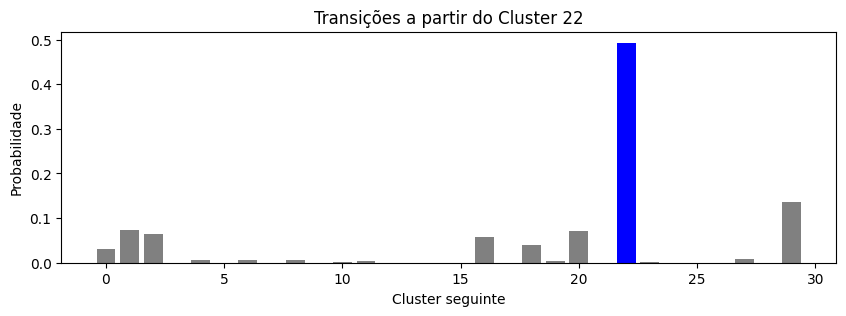

In [231]:
from collections import Counter

# df = df.sort_index()
cluster_seq = df['cluster_id'].values

n_clusters = F.shape[1]
trans_mat = np.zeros((n_clusters, n_clusters))

for (a, b) in zip(cluster_seq[:-1], cluster_seq[1:]):
    trans_mat[a, b] += 1

# Normaliza por linha
trans_mat = trans_mat / trans_mat.sum(axis=1, keepdims=True)


for cluster in [0,2,22]:
    plt.figure(figsize=(10, 3))
    plt.bar(range(n_clusters), trans_mat[cluster], color='gray')
    plt.bar(cluster, trans_mat[cluster, cluster], color='blue')  # destaca a persistência
    plt.title(f'Transições a partir do Cluster {cluster}')
    plt.xlabel('Cluster seguinte')
    plt.ylabel('Probabilidade')
    plt.show()


In [232]:
from collections import defaultdict

persist_counts = defaultdict(lambda: [0, 0])  # [ocorrências, persistências]

for i in range(len(cluster_seq) - 1):
    c_now = cluster_seq[i]
    c_next = cluster_seq[i + 1]
    persist_counts[c_now][0] += 1
    if c_now == c_next:
        persist_counts[c_now][1] += 1

# Exibe só os clusters de interesse
for cluster in [0,2,22]:
    total, repeats = persist_counts[cluster]
    perc = repeats / total if total > 0 else 0
    print(f"Cluster {cluster}: {perc:.2%} de persistência ({repeats}/{total})")


Cluster 0: 34.18% de persistência (256/749)
Cluster 2: 64.92% de persistência (409/630)
Cluster 22: 49.29% de persistência (349/708)
